## Automatic Classification of Software Artifacts in Open-Source Applications
**Approaches:**  
Nest CV  
Conventional ML using TF-IDF;  
RNN with the use of GloVe;  
Traditional ML with the use of GloVe.

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
!pip install silence_tensorflow
!pip install pycm
!pip install lime
!pip install transformers
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [6]:
import os
default_path = "/content/gdrive/MyDrive/Colab Notebooks/Automatic Software Artifacts"
os.chdir(default_path)

In [7]:
import warnings
import numpy as np
import pandas as pd
import tensorflow
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Conv1D, GlobalMaxPooling1D, LSTM, SpatialDropout1D, Input, Flatten, MaxPooling1D
from sklearn.utils import shuffle
from tensorflow.keras.layers import Embedding
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns
# for processing
import nltk
import re
# for bag-of-words
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn import feature_selection
# Metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score, accuracy_score
from sklearn.metrics import roc_curve, auc
# from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,roc_curve,auc, accuracy_score

from pycm import *
# for explainer
from lime import lime_text
# for word embedding
import gensim
import gensim.downloader as gensim_api
# for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K
# for bert language model
# import transformers
# Classifiers

# For GloVe
import os
import pickle

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn import svm
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB, ComplementNB

from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras import utils

import matplotlib as mpl
# Set the default color cycle
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=["b", "k", "c"]) 

import utils_functions as uf

%matplotlib inline
np.random.seed(7)

warnings.filterwarnings("ignore")

In [8]:
# Global parameters
#root folder
root_folder='.'
data_folder_name='data'
glove_filename='glove.42B.300d.txt'

train_filename='train.csv'
# Variable for data directory
DATA_PATH = os.path.abspath(os.path.join(root_folder, data_folder_name))
glove_path = os.path.abspath(os.path.join(DATA_PATH, glove_filename))

# Both train and test set are in the root data directory
train_path = DATA_PATH
test_path = DATA_PATH

#Relevant columns
TEXT_COLUMN = 'text'
TARGET_COLUMN = 'target'

### Read and Show a Data Sample

In [9]:
file = 'aug_original_dataset.csv'
df = pd.read_csv(file,encoding='ISO-8859-1')

In [10]:
df.sample(5)

,Label,Text
248,List of Contributors,unisys s par drivers m ben romer sparmaintaine...
245,List of Contributors,list of maintainers and how to submit kernel c...
193,Release Notes,changes since the graph now has colors there a...
145,Contributors' Guide,contributing guidelines and agreement before c...
98,License,the mit license copyright c automattic dev clo...


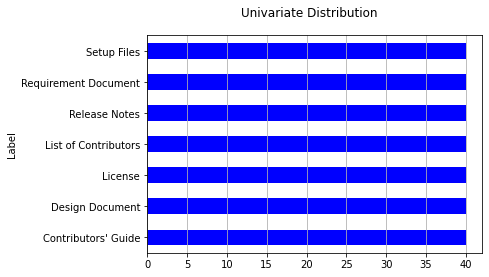

In [11]:
fig, ax = plt.subplots()
fig.suptitle("Univariate Distribution", fontsize=12)
df["Label"].reset_index().groupby("Label").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

### Feature Engineering - Tf-Idf (advanced variant of BoW)

In [ ]:
# Tf-Idf (advanced variant of BoW)
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,2))

### Create the feature matrix

Text(0.5, 1.0, 'Sparse Matrix Sample')

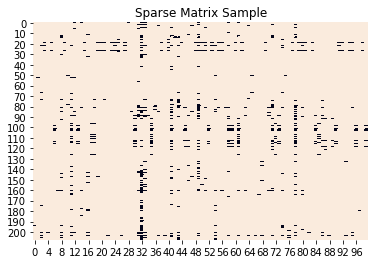

In [ ]:
corpus = df["Text"]
vectorizer.fit(corpus)
X = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

sns.heatmap(X.todense()[:,np.random.randint(0,X.shape[1],100)]==0, vmin=0, vmax=1,
            cbar=False).set_title('Sparse Matrix Sample')

In [ ]:
# The position of a certain word (example)
word = "java"
dic_vocabulary[word]

4459

### Feature Selection
In order to drop some columns and reduce the matrix dimensionality:
  1. Treat each category as binary (for example, the “Design Document” category is 1 and 0 for the others);  
  2. Perform a Chi-Square test to determine whether a feature and the (binary) target are independent;  
  3. keep only the features with a certain p-value from the Chi-Square test.

In [ ]:
y = df["Label"]
X_names = vectorizer.get_feature_names()
p_value_limit = 0.90
df_features = pd.DataFrame()
print("Initial dimension", len(X_names))
# perform a Chi-Square test to determine whether a feature and the (binary) target are independent
# keep only the features with a certain p-value from the Chi-Square test.
for cat in np.unique(y):
    chi2, p = feature_selection.chi2(X, y==cat)
    df_features = df_features.append(pd.DataFrame(
                   {"feature":X_names, "score":1-p, "Label":cat}))
    df_features = df_features.sort_values(["Label","score"], 
                    ascending=[True,False])
    df_features = df_features[df_features["score"]>p_value_limit]
X_names = df_features["feature"].unique().tolist()
print("Final dimension", len(X_names))

Initial dimension 10000
Final dimension 354


### Selected Features Sample

In [ ]:
for cat in np.unique(y):
   print("# {}:".format(cat))
   print("  . selected features:",
         len(df_features[df_features["Label"]==cat]))
   print("  . top features:", ",".join(
df_features[df_features["Label"]==cat]["feature"].values[:10]))
   print(" ")

# Contributors' Guide:
  . selected features: 25
  . top features: pull request,pull,request,test,issu,mechan,selenium,plea,fork,cla
 
# Design Document:
  . selected features: 47
  . top features: design pattern,counter,messageloggerq,messageloggerscrib,item,breakpoint,observ,autoexcept,pattern,messagesend
 
# License:
  . selected features: 174
  . top features: softwar,licens,copyright,copi,warranti,shall,distribut,notic,permiss,deal softwar
 
# List of Contributors:
  . selected features: 39
  . top features: martin,origin author,driver,com,gmail,gmail com,net,de,maintain,chri
 
# Release Notes:
  . selected features: 19
  . top features: fix,ad,gitx,updat,view,commit view,add,chang,chang ad,johann
 
# Requirement Document:
  . selected features: 28
  . top features: mount,marker,block,speakup,uml,column,world,codec,filesystem,audio
 
# Setup Files:
  . selected features: 22
  . top features: grunt,docker,mock,url http,person cz,grunt contrib,cz,contrib,mock person,nova
 


### Refit and Reduce Dimensionality

Text(0.5, 1.0, 'Sparse Matrix Sample')

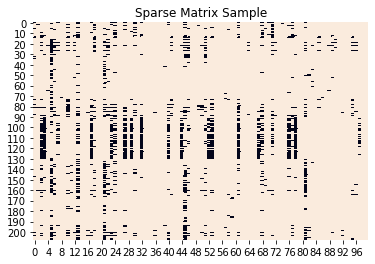

In [ ]:
vectorizer = feature_extraction.text.TfidfVectorizer(vocabulary=X_names)
vectorizer.fit(corpus)
X = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

sns.heatmap(X.todense()[:,np.random.randint(0,X.shape[1],100)]==0,
            vmin=0, vmax=1, cbar=False).set_title('Sparse Matrix Sample')

### Classifier

In [12]:
# Model Design
clf1 = svm.SVC(gamma='scale')
clf2 = RandomForestClassifier(n_estimators=500, random_state=1)
clf3 = MultinomialNB(alpha=0.01)
clf4 = DecisionTreeClassifier(random_state=0, max_depth=500)

svc = SVC(probability=True, kernel='linear')
ada = AdaBoostClassifier(n_estimators=50, base_estimator=svc,learning_rate=1)
ada2 = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=2),
    n_estimators=600,
    learning_rate=1.5,
    algorithm="SAMME")
ada3 = AdaBoostClassifier()
rf = RandomForestClassifier(max_depth=100, n_estimators=100, max_features=10)
# nb = naive_bayes.MultinomialNB(alpha=0.01)
nb = naive_bayes.MultinomialNB(alpha=0.0)
lr = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', class_weight='balanced', C=1500)
dt = DecisionTreeClassifier(max_depth=500)

In [ ]:
final_mean = []
conf_matrix_list_of_arrays = []
for i in range(10):

    accrs = []
    preds = []
    # conf_matrix_list_of_arrays = []
    k = 10
    fold = 0
    
    sss = StratifiedShuffleSplit(n_splits=k, test_size=0.2, random_state=0)

    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        fold += 1

        # train classifier
        model = rf.fit(X_train, y_train)
        predicted = model.predict(X_test)
        predicted_prob = model.predict_proba(X_test)
        accr = metrics.accuracy_score(y_test, predicted)

        conf_matrix = confusion_matrix(y_test, predicted)
        conf_matrix_list_of_arrays .append(conf_matrix)
    #  
        accrs.append(accr)
        preds.append(predicted)

        print(f'Iteração: {i+1} Fold: {fold} Accuracy: {accr}, Mean Accuracy: {sum(accrs)/fold}')
    print("-------------------------------------------")
    final_mean.append(sum(accrs)/k)

mean_of_conf_matrix_arrays = np.mean(conf_matrix_list_of_arrays, axis=0)

Iteração: 1 Fold: 1 Accuracy: 0.7380952380952381, Mean Accuracy: 0.7380952380952381
Iteração: 1 Fold: 2 Accuracy: 0.7619047619047619, Mean Accuracy: 0.75
Iteração: 1 Fold: 3 Accuracy: 0.7142857142857143, Mean Accuracy: 0.7380952380952381
Iteração: 1 Fold: 4 Accuracy: 0.8095238095238095, Mean Accuracy: 0.7559523809523809
Iteração: 1 Fold: 5 Accuracy: 0.8809523809523809, Mean Accuracy: 0.780952380952381
Iteração: 1 Fold: 6 Accuracy: 0.6904761904761905, Mean Accuracy: 0.7658730158730158
Iteração: 1 Fold: 7 Accuracy: 0.7857142857142857, Mean Accuracy: 0.7687074829931972
Iteração: 1 Fold: 8 Accuracy: 0.7380952380952381, Mean Accuracy: 0.7648809523809523
Iteração: 1 Fold: 9 Accuracy: 0.7380952380952381, Mean Accuracy: 0.7619047619047619
Iteração: 1 Fold: 10 Accuracy: 0.7142857142857143, Mean Accuracy: 0.7571428571428571
-------------------------------------------
Iteração: 2 Fold: 1 Accuracy: 0.6666666666666666, Mean Accuracy: 0.6666666666666666
Iteração: 2 Fold: 2 Accuracy: 0.78571428571428

Iteração: 10 Fold: 5 Accuracy: 0.8095238095238095, Mean Accuracy: 0.7666666666666666
Iteração: 10 Fold: 6 Accuracy: 0.6666666666666666, Mean Accuracy: 0.75
Iteração: 10 Fold: 7 Accuracy: 0.7380952380952381, Mean Accuracy: 0.7482993197278912
Iteração: 10 Fold: 8 Accuracy: 0.7619047619047619, Mean Accuracy: 0.75
Iteração: 10 Fold: 9 Accuracy: 0.7619047619047619, Mean Accuracy: 0.7513227513227513
Iteração: 10 Fold: 10 Accuracy: 0.6904761904761905, Mean Accuracy: 0.7452380952380953
-------------------------------------------


In [ ]:
print(f'Iterações: {len(final_mean)} | CV: {fold} | Média Final: {sum(final_mean)/len(final_mean)}')

Iterações: 10 | CV: 10 | Média Final: 0.7461904761904762


### Evaluate

#### Plot metrics resume and Confusion Matrix

                                          Metrics Resume                                          
Class Name          	 Precision	    Recall	  F1-Score	       MCC	       AUC
Contributors' Guide 	      0.86	      0.86	      0.86	      0.83	      0.91
Design Document     	       1.0	      0.33	       0.5	      0.56	      0.67
License             	       1.0	       1.0	       1.0	       1.0	       1.0
List of Contributors	       1.0	       0.6	      0.75	      0.75	       0.8
Release Notes       	      0.88	       1.0	      0.93	      0.92	      0.98
Requirement Document	       1.0	      0.33	       0.5	      0.56	      0.67
Setup Files         	      0.55	       1.0	      0.71	      0.68	      0.92

Macro Average       	       0.9	      0.73	      0.75	      0.76	      0.85
Micro Average       	      0.82	      0.82	      0.82	      0.68	      0.89


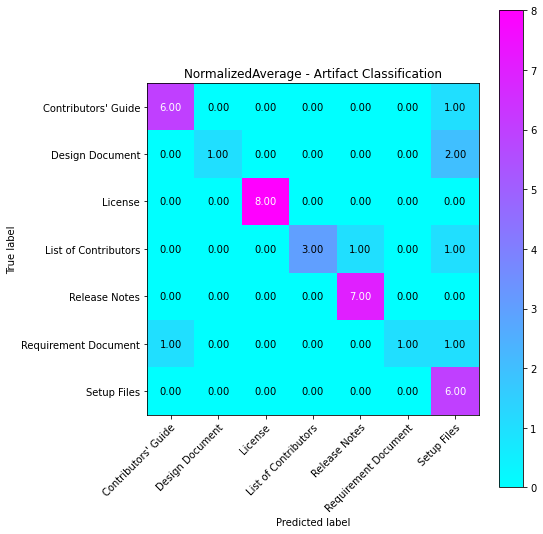

In [ ]:
uf.custom_metrics(mean_of_conf_matrix_arrays, np.unique(y_test))

### Voting Classifier

In [ ]:
final_mean = []
conf_matrix_list_of_arrays = []
for i in range(10):

    accrs = []
    preds = []
    # conf_matrix_list_of_arrays = []
    k = 10
    fold = 0
    
    sss = StratifiedShuffleSplit(n_splits=k, test_size=0.2, random_state=0)

    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        fold += 1

        # train classifier
        model = VotingClassifier(estimators=[
        ('svm', clf1),('rf', clf2), ('mnb', clf3), ('tree', clf4)], voting='hard',weights=[1,1,2,1])
        model = model.fit(X_train, y_train)
        
        predicted = model.predict(X_test)
        accr = metrics.accuracy_score(y_test, predicted)

        conf_matrix = confusion_matrix(y_test, predicted)
        conf_matrix_list_of_arrays .append(conf_matrix)
    #  
        accrs.append(accr)
        preds.append(predicted)

        print(f'Iteração: {i+1} Fold: {fold} Accuracy: {accr}, Mean Accuracy: {sum(accrs)/fold}')
    print("-------------------------------------------")
    final_mean.append(sum(accrs)/k)

mean_of_conf_matrix_arrays = np.mean(conf_matrix_list_of_arrays, axis=0)

Iteração: 1 Fold: 1 Accuracy: 0.8095238095238095, Mean Accuracy: 0.8095238095238095
Iteração: 1 Fold: 2 Accuracy: 0.8095238095238095, Mean Accuracy: 0.8095238095238095
Iteração: 1 Fold: 3 Accuracy: 0.7619047619047619, Mean Accuracy: 0.7936507936507936
Iteração: 1 Fold: 4 Accuracy: 0.7857142857142857, Mean Accuracy: 0.7916666666666666
Iteração: 1 Fold: 5 Accuracy: 0.7619047619047619, Mean Accuracy: 0.7857142857142857
Iteração: 1 Fold: 6 Accuracy: 0.7142857142857143, Mean Accuracy: 0.7738095238095237
Iteração: 1 Fold: 7 Accuracy: 0.7857142857142857, Mean Accuracy: 0.7755102040816325
Iteração: 1 Fold: 8 Accuracy: 0.8571428571428571, Mean Accuracy: 0.7857142857142856
Iteração: 1 Fold: 9 Accuracy: 0.7857142857142857, Mean Accuracy: 0.7857142857142856
Iteração: 1 Fold: 10 Accuracy: 0.7857142857142857, Mean Accuracy: 0.7857142857142856
-------------------------------------------
Iteração: 2 Fold: 1 Accuracy: 0.8095238095238095, Mean Accuracy: 0.8095238095238095
Iteração: 2 Fold: 2 Accuracy: 0

Iteração: 10 Fold: 4 Accuracy: 0.7857142857142857, Mean Accuracy: 0.7916666666666666
Iteração: 10 Fold: 5 Accuracy: 0.7619047619047619, Mean Accuracy: 0.7857142857142857
Iteração: 10 Fold: 6 Accuracy: 0.7142857142857143, Mean Accuracy: 0.7738095238095237
Iteração: 10 Fold: 7 Accuracy: 0.7857142857142857, Mean Accuracy: 0.7755102040816325
Iteração: 10 Fold: 8 Accuracy: 0.8571428571428571, Mean Accuracy: 0.7857142857142856
Iteração: 10 Fold: 9 Accuracy: 0.7857142857142857, Mean Accuracy: 0.7857142857142856
Iteração: 10 Fold: 10 Accuracy: 0.7857142857142857, Mean Accuracy: 0.7857142857142856
-------------------------------------------


In [ ]:
print(f'Iterações: {len(final_mean)} | CV: {fold} | Média Final: {sum(final_mean)/len(final_mean)}')

Iterações: 10 | CV: 10 | Média Final: 0.7857142857142856


### Evaluate

#### Plot metrics resume and Confusion Matrix

                                          Metrics Resume                                          
Class Name          	 Precision	    Recall	  F1-Score	       MCC	       AUC
Contributors' Guide 	      0.78	       1.0	      0.88	      0.85	      0.97
Design Document     	       1.0	      0.33	       0.5	      0.56	      0.67
License             	       1.0	       1.0	       1.0	       1.0	       1.0
List of Contributors	       1.0	       1.0	       1.0	       1.0	       1.0
Release Notes       	       1.0	      0.88	      0.93	      0.92	      0.94
Requirement Document	       0.5	       0.5	       0.5	      0.47	      0.74
Setup Files         	      0.71	      0.83	      0.77	      0.73	      0.89

Macro Average       	      0.86	      0.79	       0.8	      0.79	      0.88
Micro Average       	      0.87	      0.87	      0.87	      0.73	      0.92


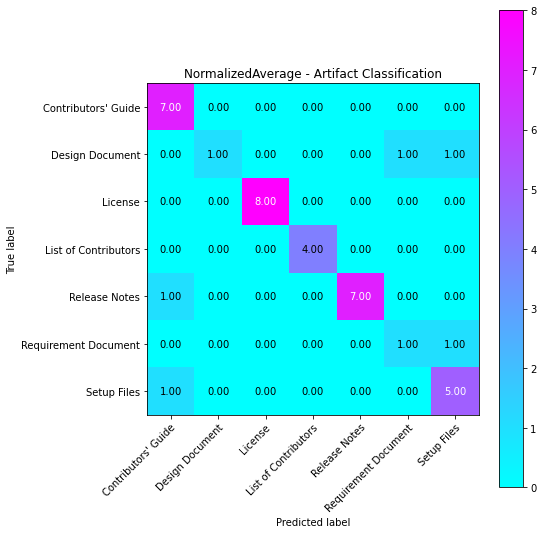

In [ ]:
uf.custom_metrics(mean_of_conf_matrix_arrays, np.unique(y_test))

## GloVe

### Loading the model (glove.42B.300d)
The GloVe 42B.300d, is a Common Crawl (42B tokens, 1.9M vocab, uncased, 300d vectors, 1.75 GB download).

In [11]:
# We just need to run this code once, the function glove2word2vec saves the Glove embeddings in the word2vec format 
# that will be loaded in the next section
from gensim.scripts.glove2word2vec import glove2word2vec

word2vec_output_file = glove_filename+'.word2vec'
# glove2word2vec(glove_path, word2vec_output_file)

In [12]:
# load the Stanford GloVe model
from gensim.models import KeyedVectors
word2vec_output_file = glove_filename+'.word2vec'
word_vect = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

In [15]:
#Show a word embedding
print('King: ',word_vect.get_vector('king'))

result = word_vect.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)

print('Most similar word to King + Woman: ', result)

King:  [-2.7381e-01  2.6752e-01  1.1490e-02 -1.5876e-01 -6.8417e-02  6.1086e-01
 -1.7651e+00 -5.5161e-01 -5.7723e-01 -2.7816e-02  4.5391e-03  4.2403e-01
  7.6693e-03  4.1675e-01  1.5134e-01 -1.1986e-01 -5.7090e-01 -7.6831e-01
  4.3965e-02  2.2138e-01  5.0782e-01  8.0745e-02  1.0530e-01 -1.5478e-01
  3.0112e-01 -5.0475e-01 -4.1413e-01  4.7806e-01  1.4708e-01  3.7711e-02
  1.2259e-02 -5.8732e-01 -1.7254e-01 -4.8854e-01  2.0883e-01 -2.3158e-01
  4.0798e-03  7.8209e-02 -1.2726e-01  1.6076e-03  1.1017e-01  7.3764e-01
 -3.6646e-01 -3.3482e-01  1.7398e-01 -1.6575e-01 -7.5085e-02 -1.4085e-01
  2.5734e-01  6.4029e-01  6.3846e-01  5.9132e-02 -1.7128e-01  3.9512e-01
  2.9804e-01  3.7342e-02 -4.1155e-01  2.0047e-01 -3.9340e-01 -2.9488e-01
  1.1896e-01  2.6823e-01  5.1301e-01 -3.8040e-01 -1.9490e-01  2.9677e-02
  1.7390e-01 -3.5106e-02 -1.5921e-02 -1.3907e-01 -4.3194e-01  1.5473e-02
 -2.7858e-01  2.1920e-01  2.0801e-01 -5.9925e-02  1.1125e-04 -4.3176e-01
  1.4686e-01  4.8844e-01  6.0544e-02 -4.6726

In [16]:
# total words in vocab
vocab_obj = word_vect.vocab["word"]
vocab_obj.count

1916801

In [ ]:
# top 20 most similar words
word_vect.most_similar(word, topn=20)

[('c++', 0.687698245048523),
 ('j2ee', 0.6488214731216431),
 ('javascript', 0.6401231288909912),
 ('xml', 0.6021153926849365),
 ('php', 0.5984039306640625),
 ('perl', 0.5907211303710938),
 ('api', 0.588263750076294),
 ('python', 0.5860908031463623),
 ('programming', 0.5810009837150574),
 ('jsp', 0.579157829284668),
 ('developer', 0.5787414908409119),
 ('oracle', 0.5719089508056641),
 ('sql', 0.5692706108093262),
 ('applet', 0.555595874786377),
 ('linux', 0.5553056597709656),
 ('j2me', 0.552773118019104),
 ('gui', 0.5500690937042236),
 ('mysql', 0.5494028329849243),
 ('scripting', 0.5474516153335571),
 ('html', 0.5473135709762573)]

#### A Word and its Context (3D)

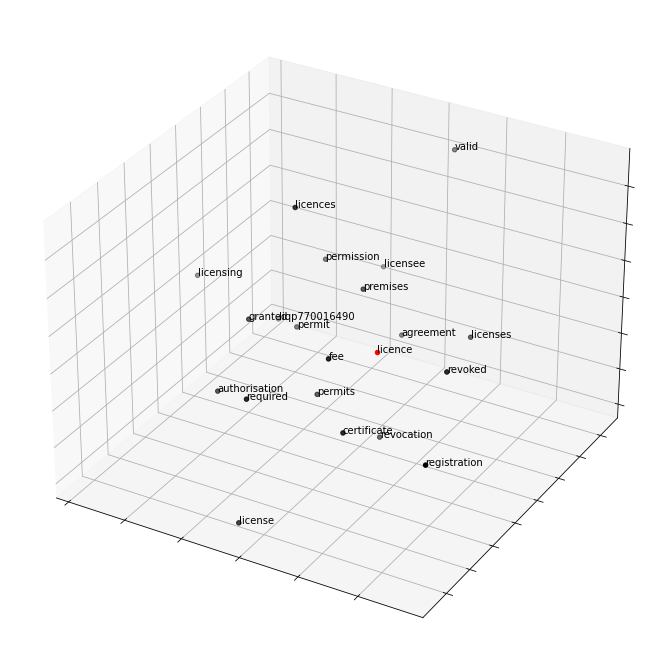

In [ ]:
word = "licence"
fig = plt.figure(figsize=(15,12))
## word embedding
tot_words = [word] + [tupla[0] for tupla in 
                 word_vect.most_similar(word, topn=20)]
X = word_vect[tot_words]
## pca to reduce dimensionality from 100 to 3
pca = manifold.TSNE(perplexity=40, n_components=3, init='pca')
X = pca.fit_transform(X)
## create dataframe
dt_ = pd.DataFrame(X, index=tot_words, columns=["x","y","z"])
dt_["input"] = 0
dt_["input"].iloc[0:1] = 1
## plot 3d
from mpl_toolkits.mplot3d import Axes3D
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dt_[dt_["input"]==0]['x'], 
           dt_[dt_["input"]==0]['y'], 
           dt_[dt_["input"]==0]['z'], c="black")
ax.scatter(dt_[dt_["input"]==1]['x'], 
           dt_[dt_["input"]==1]['y'], 
           dt_[dt_["input"]==1]['z'], c="red")
ax.set(xlabel=None, ylabel=None, zlabel=None, xticklabels=[], 
       yticklabels=[], zticklabels=[])
for label, row in dt_[["x","y","z"]].iterrows():
    x, y, z = row
    ax.text(x, y, z, s=label)

### Feature Engineering

#### Transform the Corpus into Padded Sequences

In [13]:
corpus = df["Text"]

## create list of lists of unigrams
lst_corpus = []
for string in corpus:
   lst_words = string.split()
   lst_grams = [" ".join(lst_words[i:i+1]) 
               for i in range(0, len(lst_words), 1)]
   lst_corpus.append(lst_grams)

## detect bigrams and trigrams
bigrams_detector = gensim.models.phrases.Phrases(lst_corpus, 
                 delimiter=" ".encode(), min_count=5, threshold=10)
bigrams_detector = gensim.models.phrases.Phraser(bigrams_detector)
trigrams_detector = gensim.models.phrases.Phrases(bigrams_detector[lst_corpus], 
            delimiter=" ".encode(), min_count=5, threshold=10)
trigrams_detector = gensim.models.phrases.Phraser(trigrams_detector)

In [14]:
## tokenize text
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', 
                     oov_token="NaN", 
                     filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(lst_corpus)
dic_vocabulary = tokenizer.word_index
## create sequence
lst_text2seq= tokenizer.texts_to_sequences(lst_corpus)
## padding sequence
X = kprocessing.sequence.pad_sequences(lst_text2seq, 
                    maxlen=15, padding="post", truncating="post")

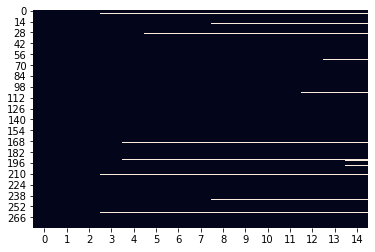

In [15]:
sns.heatmap(X==0, vmin=0, vmax=1, cbar=False)
plt.show()

### Create the Matrix of Embedding

In [16]:
## start the matrix (length of vocabulary x vector size) with all 0s
embeddings = np.zeros((len(dic_vocabulary)+1, 300))
for word,idx in dic_vocabulary.items():
    ## update the row with vector
    try:
        embeddings[idx] =  word_vect[word]
    ## if word not in model then skip and the row stays all 0s
    except:
        pass

In [17]:
#It can be navigated by word id, which can be obtained from the vocabulary.
word = "script"
print("dic[word]:", dic_vocabulary[word], "|idx")
print("embeddings[idx]:", embeddings[dic_vocabulary[word]].shape, 
      "|vector")

dic[word]: 600 |idx
embeddings[idx]: (300,) |vector


### Deep Learning Model (Recurrent Neural Network)

In [34]:
from tensorflow.keras.constraints import max_norm
def fit_bert_classif(X_train, y_train, X_test, encode_y=False, dic_y_mapping=None, model=None, epochs=1, batch_size=16):
    ## encode y
    if encode_y is True:
        dic_y_mapping = {n:label for n,label in enumerate(np.unique(y_train))}
        inverse_dic = {v:k for k,v in dic_y_mapping.items()}
        y_train = np.array( [inverse_dic[y] for y in y_train] )
    # print(dic_y_mapping)
    
    ## model
    if model is None:
        # input
        x_in = layers.Input(shape=(X_train.shape[1],))

        # embedding
        X = layers.Embedding(input_dim=embeddings.shape[0],  
                              output_dim=embeddings.shape[1], 
                              weights=[embeddings],
                              input_length=X_train.shape[1], trainable=True)(x_in)
        # 2 layers of bidirectional lstm
        X = layers.Bidirectional(layers.LSTM(180, recurrent_dropout=0.1,  return_sequences=True))(X)
        X = layers.Bidirectional(layers.LSTM(90))(X)

        # ## final dense 
        # X = layers.Dense(32, activation='tanh', kernel_constraint=max_norm(11))(X)
        # X = layers.Dense(32, activation='relu')(X)
        # X = layers.Dropout(0.1)(X)

        y_out = layers.Dense(len(np.unique(y_train)), activation='softmax')(X)
        ## compile
        model = Model(x_in, y_out)
        opt = Adam(learning_rate=0.1)
        model.compile(loss='sparse_categorical_crossentropy',
                    optimizer='adam', metrics=['accuracy'])
        # print(model.summary())
        
    ## train
    verbose = 1 if epochs > 1 else 2
    training = model.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=epochs, shuffle=True, verbose=verbose, validation_split=0.2)
    if epochs > 1:
        utils_plot_keras_training(training)
    
    ## test
    predicted_prob = model.predict(X_test)
    predicted = [dic_y_mapping[np.argmax(pred)] for pred in predicted_prob] if encode_y is True else [np.argmax(pred)]
    return training.model, predicted_prob, predicted

'''
Plot loss and metrics of keras training.
'''
def utils_plot_keras_training(training):
    metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,3))
    
    ## training
    ax[0].set(title="Training")
    ax11 = ax[0].twinx()
    ax[0].plot(training.history['loss'], color='black')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss', color='black')
    for metric in metrics:
        ax11.plot(training.history[metric], label=metric)
    ax11.set_ylabel("Score", color='steelblue')
    ax11.legend()
    
    ## validation
    ax[1].set(title="Validation")
    ax22 = ax[1].twinx()
    ax[1].plot(training.history['val_loss'], color='black')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss', color='black')
    for metric in metrics:
        ax22.plot(training.history['val_'+metric], label=metric)
    ax22.set_ylabel("Score", color="steelblue")
    plt.show()

### Define Target

In [19]:
y = df["Label"].values

### Train the Model

Epoch 1/5
23/23 [==============================] - 12s 196ms/step - loss: 1.7789 - accuracy: 0.2852 - val_loss: 1.1530 - val_accuracy: 0.5778
Epoch 2/5
23/23 [==============================] - 3s 148ms/step - loss: 0.6509 - accuracy: 0.8494 - val_loss: 0.8601 - val_accuracy: 0.7111
Epoch 3/5
23/23 [==============================] - 4s 154ms/step - loss: 0.1688 - accuracy: 0.9561 - val_loss: 0.7791 - val_accuracy: 0.7778
Epoch 4/5
23/23 [==============================] - 4s 152ms/step - loss: 0.0879 - accuracy: 0.9607 - val_loss: 0.8280 - val_accuracy: 0.8444
Epoch 5/5
23/23 [==============================] - 3s 149ms/step - loss: 0.0229 - accuracy: 0.9931 - val_loss: 1.0993 - val_accuracy: 0.7778


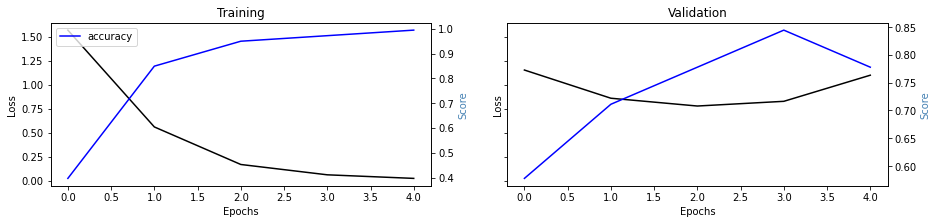

Iteração: 1 Fold: 1 Accuracy: 0.8392857142857143, Mean Accuracy: 0.8392857142857143
Epoch 1/5
23/23 [==============================] - 9s 185ms/step - loss: 1.8159 - accuracy: 0.2856 - val_loss: 1.1249 - val_accuracy: 0.4889
Epoch 2/5
23/23 [==============================] - 3s 147ms/step - loss: 0.6230 - accuracy: 0.7742 - val_loss: 0.5744 - val_accuracy: 0.8222
Epoch 3/5
23/23 [==============================] - 3s 148ms/step - loss: 0.1546 - accuracy: 0.9817 - val_loss: 0.5645 - val_accuracy: 0.8000
Epoch 4/5
23/23 [==============================] - 3s 149ms/step - loss: 0.0292 - accuracy: 1.0000 - val_loss: 0.7008 - val_accuracy: 0.8000
Epoch 5/5
23/23 [==============================] - 3s 146ms/step - loss: 0.0058 - accuracy: 1.0000 - val_loss: 0.5929 - val_accuracy: 0.8222


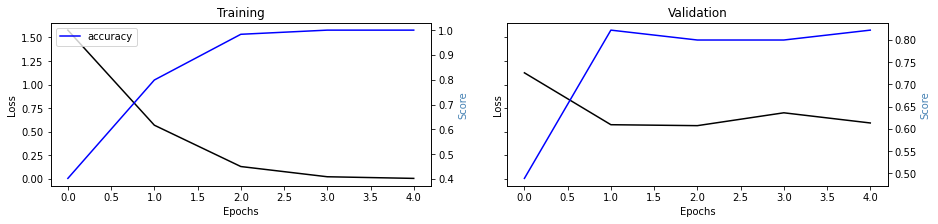

Iteração: 1 Fold: 2 Accuracy: 0.8035714285714286, Mean Accuracy: 0.8214285714285714
Epoch 1/5
23/23 [==============================] - 10s 196ms/step - loss: 1.8495 - accuracy: 0.2245 - val_loss: 1.2281 - val_accuracy: 0.5556
Epoch 2/5
23/23 [==============================] - 4s 155ms/step - loss: 0.7645 - accuracy: 0.8069 - val_loss: 1.1644 - val_accuracy: 0.6444
Epoch 3/5
23/23 [==============================] - 3s 147ms/step - loss: 0.2024 - accuracy: 0.9501 - val_loss: 0.7312 - val_accuracy: 0.8000
Epoch 4/5
23/23 [==============================] - 3s 149ms/step - loss: 0.0873 - accuracy: 0.9701 - val_loss: 1.1198 - val_accuracy: 0.7778
Epoch 5/5
23/23 [==============================] - 4s 155ms/step - loss: 0.0718 - accuracy: 0.9820 - val_loss: 1.0691 - val_accuracy: 0.7556


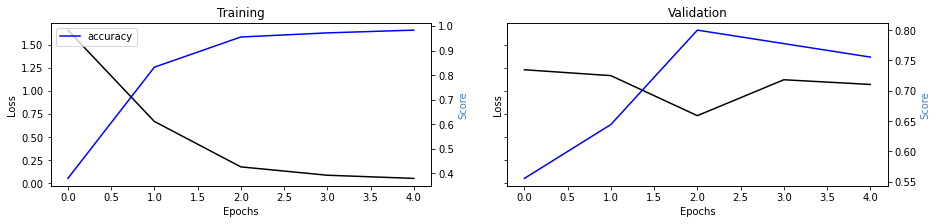

Iteração: 1 Fold: 3 Accuracy: 0.8035714285714286, Mean Accuracy: 0.8154761904761904
Epoch 1/5
23/23 [==============================] - 10s 209ms/step - loss: 1.7775 - accuracy: 0.3306 - val_loss: 1.1408 - val_accuracy: 0.5556
Epoch 2/5
23/23 [==============================] - 4s 152ms/step - loss: 0.7930 - accuracy: 0.7351 - val_loss: 1.0924 - val_accuracy: 0.7778
Epoch 3/5
23/23 [==============================] - 4s 163ms/step - loss: 0.1197 - accuracy: 0.9825 - val_loss: 1.0315 - val_accuracy: 0.8222
Epoch 4/5
23/23 [==============================] - 4s 169ms/step - loss: 0.0310 - accuracy: 1.0000 - val_loss: 1.1873 - val_accuracy: 0.8000
Epoch 5/5
23/23 [==============================] - 3s 140ms/step - loss: 0.0511 - accuracy: 0.9811 - val_loss: 1.1328 - val_accuracy: 0.7778


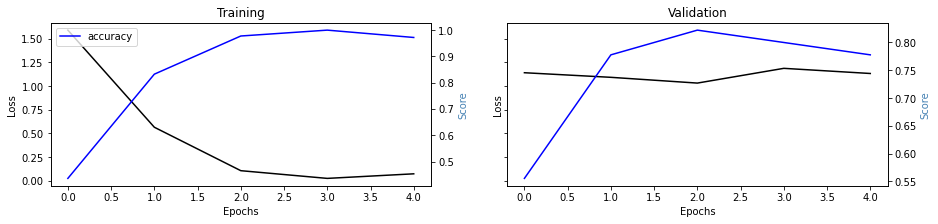

Iteração: 1 Fold: 4 Accuracy: 0.8035714285714286, Mean Accuracy: 0.8125
Epoch 1/5
23/23 [==============================] - 11s 197ms/step - loss: 1.8380 - accuracy: 0.2635 - val_loss: 1.0329 - val_accuracy: 0.7556
Epoch 2/5
23/23 [==============================] - 3s 147ms/step - loss: 0.5845 - accuracy: 0.8517 - val_loss: 0.6968 - val_accuracy: 0.8444
Epoch 3/5
23/23 [==============================] - 3s 150ms/step - loss: 0.1676 - accuracy: 0.9444 - val_loss: 0.6310 - val_accuracy: 0.8444
Epoch 4/5
23/23 [==============================] - 3s 143ms/step - loss: 0.0439 - accuracy: 0.9899 - val_loss: 0.6120 - val_accuracy: 0.8667
Epoch 5/5
23/23 [==============================] - 4s 154ms/step - loss: 0.0084 - accuracy: 1.0000 - val_loss: 0.6443 - val_accuracy: 0.8667


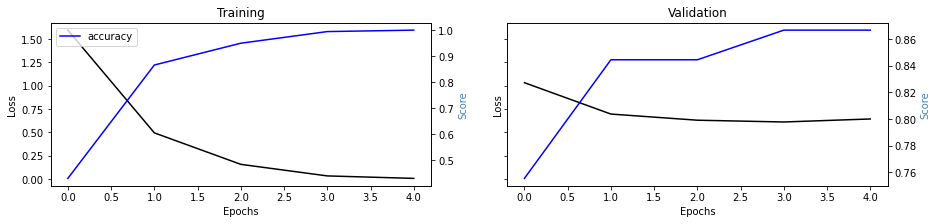

Iteração: 1 Fold: 5 Accuracy: 0.9107142857142857, Mean Accuracy: 0.8321428571428571
Epoch 1/5
23/23 [==============================] - 10s 196ms/step - loss: 1.8163 - accuracy: 0.3532 - val_loss: 1.0575 - val_accuracy: 0.7111
Epoch 2/5
23/23 [==============================] - 3s 144ms/step - loss: 0.6716 - accuracy: 0.7969 - val_loss: 0.6326 - val_accuracy: 0.7556
Epoch 3/5
23/23 [==============================] - 3s 146ms/step - loss: 0.1652 - accuracy: 0.9785 - val_loss: 0.4712 - val_accuracy: 0.8222
Epoch 4/5
23/23 [==============================] - 3s 148ms/step - loss: 0.0505 - accuracy: 1.0000 - val_loss: 1.0461 - val_accuracy: 0.7333
Epoch 5/5
23/23 [==============================] - 4s 154ms/step - loss: 0.0169 - accuracy: 1.0000 - val_loss: 0.7562 - val_accuracy: 0.8444


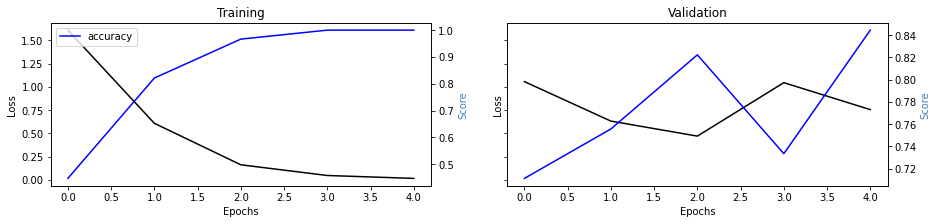

Iteração: 1 Fold: 6 Accuracy: 0.8392857142857143, Mean Accuracy: 0.8333333333333334
Epoch 1/5
23/23 [==============================] - 9s 191ms/step - loss: 1.8661 - accuracy: 0.2867 - val_loss: 1.1698 - val_accuracy: 0.6667
Epoch 2/5
23/23 [==============================] - 3s 142ms/step - loss: 0.8284 - accuracy: 0.7749 - val_loss: 0.5383 - val_accuracy: 0.8667
Epoch 3/5
23/23 [==============================] - 3s 148ms/step - loss: 0.2524 - accuracy: 0.9217 - val_loss: 0.6590 - val_accuracy: 0.8000
Epoch 4/5
23/23 [==============================] - 3s 145ms/step - loss: 0.1303 - accuracy: 0.9626 - val_loss: 0.2977 - val_accuracy: 0.8889
Epoch 5/5
23/23 [==============================] - 3s 150ms/step - loss: 0.0376 - accuracy: 0.9938 - val_loss: 0.3665 - val_accuracy: 0.9111


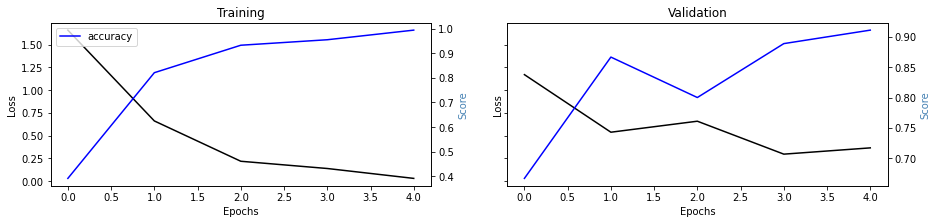

Iteração: 1 Fold: 7 Accuracy: 0.9107142857142857, Mean Accuracy: 0.8443877551020408
Epoch 1/5
23/23 [==============================] - 9s 187ms/step - loss: 1.7684 - accuracy: 0.3028 - val_loss: 1.0923 - val_accuracy: 0.6444
Epoch 2/5
23/23 [==============================] - 3s 151ms/step - loss: 0.7298 - accuracy: 0.8032 - val_loss: 0.7826 - val_accuracy: 0.6889
Epoch 3/5
23/23 [==============================] - 3s 142ms/step - loss: 0.1627 - accuracy: 0.9658 - val_loss: 0.5373 - val_accuracy: 0.8000
Epoch 4/5
23/23 [==============================] - 3s 145ms/step - loss: 0.0349 - accuracy: 0.9898 - val_loss: 0.6817 - val_accuracy: 0.8222
Epoch 5/5
23/23 [==============================] - 3s 141ms/step - loss: 0.0695 - accuracy: 0.9748 - val_loss: 0.6597 - val_accuracy: 0.8222


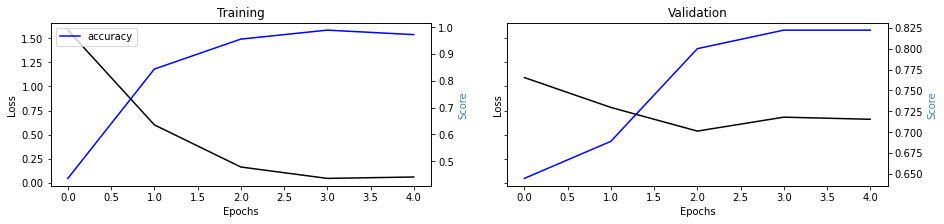

Iteração: 1 Fold: 8 Accuracy: 0.8214285714285714, Mean Accuracy: 0.8415178571428571
Epoch 1/5
23/23 [==============================] - 11s 271ms/step - loss: 1.8281 - accuracy: 0.2409 - val_loss: 1.0392 - val_accuracy: 0.6222
Epoch 2/5
23/23 [==============================] - 3s 151ms/step - loss: 0.7692 - accuracy: 0.8100 - val_loss: 0.6430 - val_accuracy: 0.6667
Epoch 3/5
23/23 [==============================] - 3s 146ms/step - loss: 0.2687 - accuracy: 0.9252 - val_loss: 0.6254 - val_accuracy: 0.8000
Epoch 4/5
23/23 [==============================] - 3s 149ms/step - loss: 0.0622 - accuracy: 0.9890 - val_loss: 0.9175 - val_accuracy: 0.7333
Epoch 5/5
23/23 [==============================] - 3s 150ms/step - loss: 0.0507 - accuracy: 0.9912 - val_loss: 0.5692 - val_accuracy: 0.8444


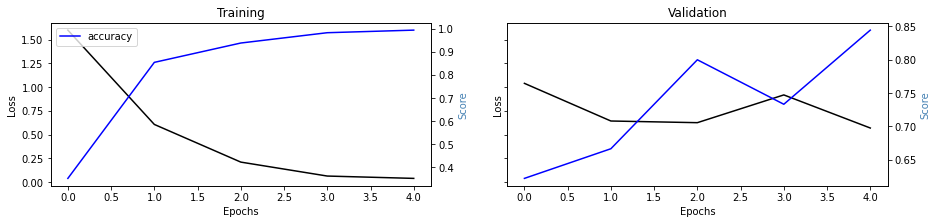

Iteração: 1 Fold: 9 Accuracy: 0.7678571428571429, Mean Accuracy: 0.8333333333333334
Epoch 1/5
23/23 [==============================] - 10s 190ms/step - loss: 1.7378 - accuracy: 0.3368 - val_loss: 1.0719 - val_accuracy: 0.6667
Epoch 2/5
23/23 [==============================] - 4s 159ms/step - loss: 0.6038 - accuracy: 0.8389 - val_loss: 1.0138 - val_accuracy: 0.6444
Epoch 3/5
23/23 [==============================] - 4s 160ms/step - loss: 0.1982 - accuracy: 0.9153 - val_loss: 0.6535 - val_accuracy: 0.8444
Epoch 4/5
23/23 [==============================] - 4s 156ms/step - loss: 0.0722 - accuracy: 0.9696 - val_loss: 0.8863 - val_accuracy: 0.8000
Epoch 5/5
23/23 [==============================] - 3s 148ms/step - loss: 0.0198 - accuracy: 0.9982 - val_loss: 0.8282 - val_accuracy: 0.8222


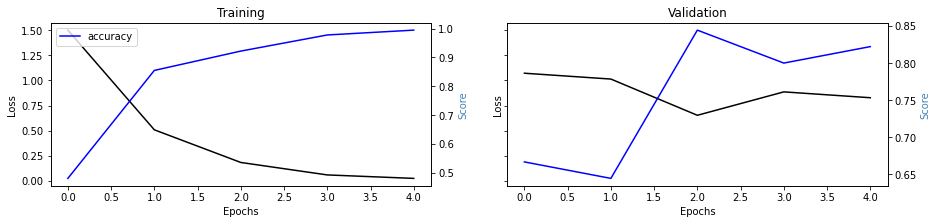

Iteração: 1 Fold: 10 Accuracy: 0.8214285714285714, Mean Accuracy: 0.8321428571428571
Epoch 1/5
23/23 [==============================] - 10s 196ms/step - loss: 1.7611 - accuracy: 0.3234 - val_loss: 1.2556 - val_accuracy: 0.5111
Epoch 2/5
23/23 [==============================] - 3s 146ms/step - loss: 0.7357 - accuracy: 0.7582 - val_loss: 0.6544 - val_accuracy: 0.8444
Epoch 3/5
23/23 [==============================] - 4s 154ms/step - loss: 0.1913 - accuracy: 0.9467 - val_loss: 0.6927 - val_accuracy: 0.7778
Epoch 4/5
23/23 [==============================] - 3s 149ms/step - loss: 0.0878 - accuracy: 0.9896 - val_loss: 0.8086 - val_accuracy: 0.8000
Epoch 5/5
23/23 [==============================] - 3s 150ms/step - loss: 0.0195 - accuracy: 1.0000 - val_loss: 0.8846 - val_accuracy: 0.8000


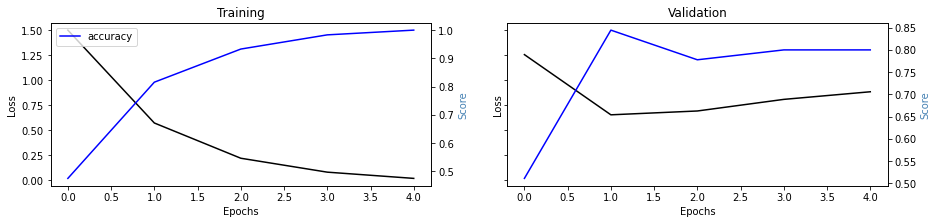

Iteração: 2 Fold: 1 Accuracy: 0.8035714285714286, Mean Accuracy: 0.8035714285714286
Epoch 1/5
23/23 [==============================] - 10s 198ms/step - loss: 1.7870 - accuracy: 0.3066 - val_loss: 1.0289 - val_accuracy: 0.6444
Epoch 2/5
23/23 [==============================] - 3s 141ms/step - loss: 0.6435 - accuracy: 0.8357 - val_loss: 0.5242 - val_accuracy: 0.8222
Epoch 3/5
23/23 [==============================] - 3s 145ms/step - loss: 0.2088 - accuracy: 0.9453 - val_loss: 0.7420 - val_accuracy: 0.7556
Epoch 4/5
23/23 [==============================] - 3s 149ms/step - loss: 0.1252 - accuracy: 0.9636 - val_loss: 0.9389 - val_accuracy: 0.7111
Epoch 5/5
23/23 [==============================] - 4s 160ms/step - loss: 0.0867 - accuracy: 0.9870 - val_loss: 0.6337 - val_accuracy: 0.7778


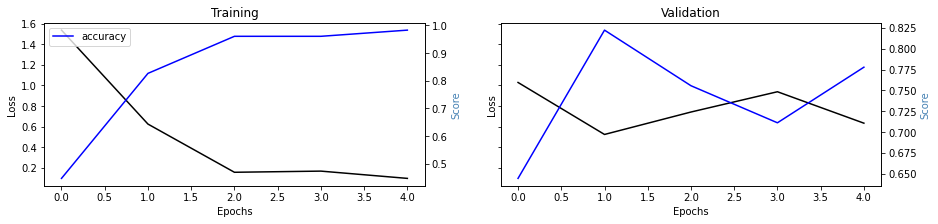

Iteração: 2 Fold: 2 Accuracy: 0.8392857142857143, Mean Accuracy: 0.8214285714285714
Epoch 1/5
23/23 [==============================] - 10s 195ms/step - loss: 1.8874 - accuracy: 0.2300 - val_loss: 1.2199 - val_accuracy: 0.5111
Epoch 2/5
23/23 [==============================] - 4s 166ms/step - loss: 0.8571 - accuracy: 0.8003 - val_loss: 0.8551 - val_accuracy: 0.6889
Epoch 3/5
23/23 [==============================] - 3s 146ms/step - loss: 0.1392 - accuracy: 0.9714 - val_loss: 1.3903 - val_accuracy: 0.6667
Epoch 4/5
23/23 [==============================] - 3s 145ms/step - loss: 0.1281 - accuracy: 0.9618 - val_loss: 0.9253 - val_accuracy: 0.7556
Epoch 5/5
23/23 [==============================] - 3s 149ms/step - loss: 0.0971 - accuracy: 0.9771 - val_loss: 0.8813 - val_accuracy: 0.8000


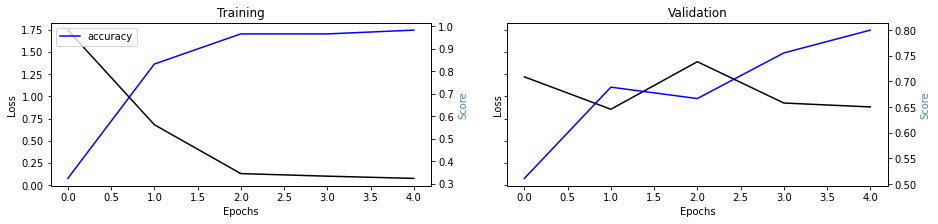

Iteração: 2 Fold: 3 Accuracy: 0.8392857142857143, Mean Accuracy: 0.8273809523809524
Epoch 1/5
23/23 [==============================] - 10s 203ms/step - loss: 1.7646 - accuracy: 0.2901 - val_loss: 1.2640 - val_accuracy: 0.6222
Epoch 2/5
23/23 [==============================] - 3s 152ms/step - loss: 0.5809 - accuracy: 0.8866 - val_loss: 1.0538 - val_accuracy: 0.6667
Epoch 3/5
23/23 [==============================] - 3s 143ms/step - loss: 0.1789 - accuracy: 0.9501 - val_loss: 0.9482 - val_accuracy: 0.7778
Epoch 4/5
23/23 [==============================] - 3s 145ms/step - loss: 0.0418 - accuracy: 0.9892 - val_loss: 0.9098 - val_accuracy: 0.8000
Epoch 5/5
23/23 [==============================] - 4s 160ms/step - loss: 0.0325 - accuracy: 0.9938 - val_loss: 1.1041 - val_accuracy: 0.7778


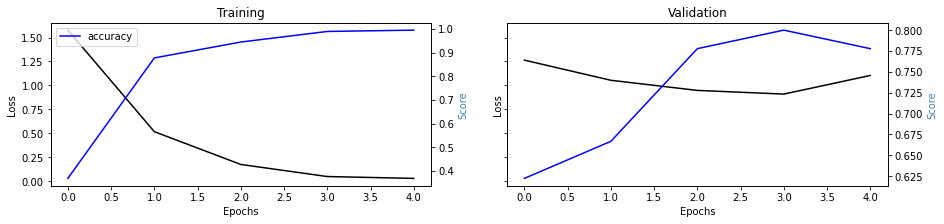

Iteração: 2 Fold: 4 Accuracy: 0.8035714285714286, Mean Accuracy: 0.8214285714285714
Epoch 1/5
23/23 [==============================] - 9s 186ms/step - loss: 1.8644 - accuracy: 0.2537 - val_loss: 1.0509 - val_accuracy: 0.7556
Epoch 2/5
23/23 [==============================] - 3s 150ms/step - loss: 0.6430 - accuracy: 0.8923 - val_loss: 0.5385 - val_accuracy: 0.8667
Epoch 3/5
23/23 [==============================] - 4s 154ms/step - loss: 0.1281 - accuracy: 0.9755 - val_loss: 0.6696 - val_accuracy: 0.8222
Epoch 4/5
23/23 [==============================] - 3s 147ms/step - loss: 0.0703 - accuracy: 0.9803 - val_loss: 0.6533 - val_accuracy: 0.8444
Epoch 5/5
23/23 [==============================] - 3s 142ms/step - loss: 0.0112 - accuracy: 1.0000 - val_loss: 0.7088 - val_accuracy: 0.8667


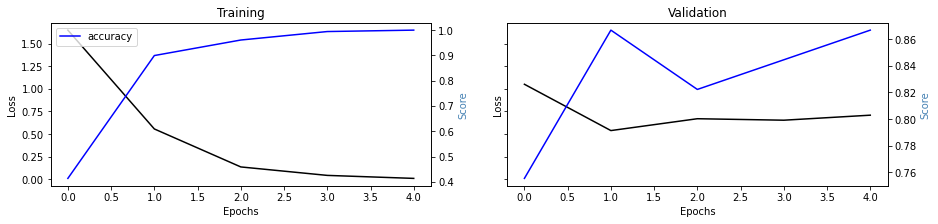

Iteração: 2 Fold: 5 Accuracy: 0.9107142857142857, Mean Accuracy: 0.8392857142857142
Epoch 1/5
23/23 [==============================] - 9s 189ms/step - loss: 1.7470 - accuracy: 0.3407 - val_loss: 1.0257 - val_accuracy: 0.6444
Epoch 2/5
23/23 [==============================] - 4s 154ms/step - loss: 0.7106 - accuracy: 0.8274 - val_loss: 0.6022 - val_accuracy: 0.7778
Epoch 3/5
23/23 [==============================] - 4s 165ms/step - loss: 0.1925 - accuracy: 0.9552 - val_loss: 0.5540 - val_accuracy: 0.7778
Epoch 4/5
23/23 [==============================] - 3s 149ms/step - loss: 0.0831 - accuracy: 0.9922 - val_loss: 0.5158 - val_accuracy: 0.8222
Epoch 5/5
23/23 [==============================] - 3s 141ms/step - loss: 0.0337 - accuracy: 0.9899 - val_loss: 0.7456 - val_accuracy: 0.8222


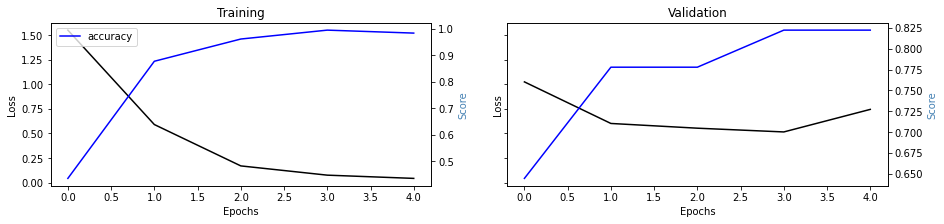

Iteração: 2 Fold: 6 Accuracy: 0.875, Mean Accuracy: 0.8452380952380952
Epoch 1/5
23/23 [==============================] - 10s 195ms/step - loss: 1.8320 - accuracy: 0.2947 - val_loss: 1.2711 - val_accuracy: 0.5111
Epoch 2/5
23/23 [==============================] - 3s 148ms/step - loss: 0.7820 - accuracy: 0.8006 - val_loss: 0.6403 - val_accuracy: 0.8444
Epoch 3/5
23/23 [==============================] - 4s 153ms/step - loss: 0.3645 - accuracy: 0.8937 - val_loss: 0.6615 - val_accuracy: 0.8222
Epoch 4/5
23/23 [==============================] - 3s 149ms/step - loss: 0.0683 - accuracy: 0.9920 - val_loss: 0.4722 - val_accuracy: 0.8667
Epoch 5/5
23/23 [==============================] - 4s 159ms/step - loss: 0.0623 - accuracy: 0.9758 - val_loss: 0.5251 - val_accuracy: 0.8444


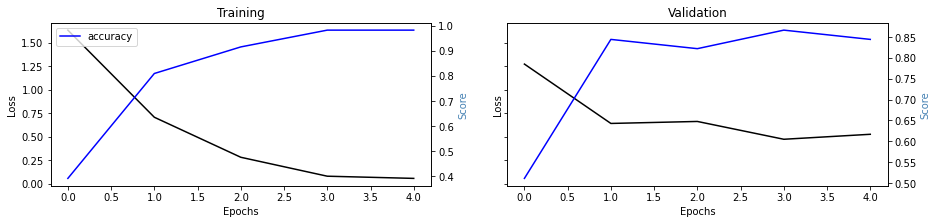

Iteração: 2 Fold: 7 Accuracy: 0.7857142857142857, Mean Accuracy: 0.836734693877551
Epoch 1/5
23/23 [==============================] - 11s 192ms/step - loss: 1.8190 - accuracy: 0.3073 - val_loss: 1.1283 - val_accuracy: 0.6000
Epoch 2/5
23/23 [==============================] - 4s 157ms/step - loss: 0.5969 - accuracy: 0.8603 - val_loss: 0.5335 - val_accuracy: 0.7778
Epoch 3/5
23/23 [==============================] - 3s 147ms/step - loss: 0.2411 - accuracy: 0.9404 - val_loss: 0.5374 - val_accuracy: 0.8000
Epoch 4/5
23/23 [==============================] - 3s 150ms/step - loss: 0.0766 - accuracy: 0.9706 - val_loss: 0.6711 - val_accuracy: 0.7333
Epoch 5/5
23/23 [==============================] - 4s 154ms/step - loss: 0.0144 - accuracy: 0.9970 - val_loss: 1.4887 - val_accuracy: 0.6222


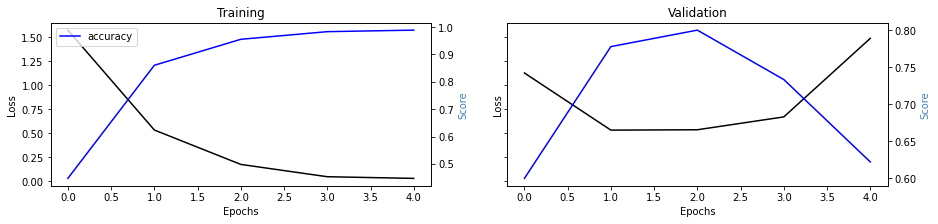

Iteração: 2 Fold: 8 Accuracy: 0.6428571428571429, Mean Accuracy: 0.8125
Epoch 1/5
23/23 [==============================] - 10s 190ms/step - loss: 1.8673 - accuracy: 0.2459 - val_loss: 1.0713 - val_accuracy: 0.6000
Epoch 2/5
23/23 [==============================] - 3s 144ms/step - loss: 0.7536 - accuracy: 0.8485 - val_loss: 0.9003 - val_accuracy: 0.6444
Epoch 3/5
23/23 [==============================] - 4s 157ms/step - loss: 0.3146 - accuracy: 0.8859 - val_loss: 0.4077 - val_accuracy: 0.8444
Epoch 4/5
23/23 [==============================] - 4s 161ms/step - loss: 0.0595 - accuracy: 0.9855 - val_loss: 0.8289 - val_accuracy: 0.8000
Epoch 5/5
23/23 [==============================] - 3s 145ms/step - loss: 0.0785 - accuracy: 0.9860 - val_loss: 0.3847 - val_accuracy: 0.8889


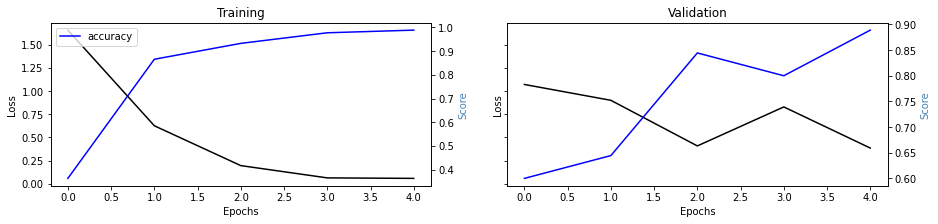

Iteração: 2 Fold: 9 Accuracy: 0.8571428571428571, Mean Accuracy: 0.8174603174603174
Epoch 1/5
23/23 [==============================] - 9s 190ms/step - loss: 1.8516 - accuracy: 0.2645 - val_loss: 1.1333 - val_accuracy: 0.6889
Epoch 2/5
23/23 [==============================] - 4s 169ms/step - loss: 0.7314 - accuracy: 0.8364 - val_loss: 0.8554 - val_accuracy: 0.7556
Epoch 3/5
23/23 [==============================] - 4s 153ms/step - loss: 0.2147 - accuracy: 0.9519 - val_loss: 0.6176 - val_accuracy: 0.8222
Epoch 4/5
23/23 [==============================] - 4s 155ms/step - loss: 0.0892 - accuracy: 0.9837 - val_loss: 0.6549 - val_accuracy: 0.8667
Epoch 5/5
23/23 [==============================] - 3s 152ms/step - loss: 0.0736 - accuracy: 0.9762 - val_loss: 0.7012 - val_accuracy: 0.8444


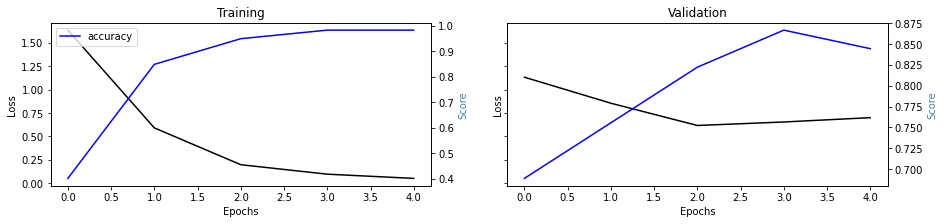

Iteração: 2 Fold: 10 Accuracy: 0.8392857142857143, Mean Accuracy: 0.8196428571428571
Epoch 1/5
23/23 [==============================] - 10s 191ms/step - loss: 1.8341 - accuracy: 0.2788 - val_loss: 1.3414 - val_accuracy: 0.5778
Epoch 2/5
23/23 [==============================] - 4s 163ms/step - loss: 0.8503 - accuracy: 0.7225 - val_loss: 0.7827 - val_accuracy: 0.7556
Epoch 3/5
23/23 [==============================] - 4s 156ms/step - loss: 0.2814 - accuracy: 0.9090 - val_loss: 0.5827 - val_accuracy: 0.8000
Epoch 4/5
23/23 [==============================] - 4s 150ms/step - loss: 0.1049 - accuracy: 0.9713 - val_loss: 0.4486 - val_accuracy: 0.8444
Epoch 5/5
23/23 [==============================] - 4s 152ms/step - loss: 0.0555 - accuracy: 0.9757 - val_loss: 0.5994 - val_accuracy: 0.8000


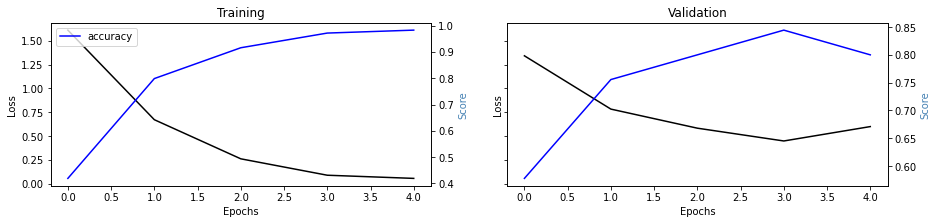

Iteração: 3 Fold: 1 Accuracy: 0.8392857142857143, Mean Accuracy: 0.8392857142857143
Epoch 1/5
23/23 [==============================] - 11s 189ms/step - loss: 1.7275 - accuracy: 0.3564 - val_loss: 1.2431 - val_accuracy: 0.4889
Epoch 2/5
23/23 [==============================] - 4s 166ms/step - loss: 0.6765 - accuracy: 0.7838 - val_loss: 0.5221 - val_accuracy: 0.8444
Epoch 3/5
23/23 [==============================] - 4s 158ms/step - loss: 0.1686 - accuracy: 0.9494 - val_loss: 0.4726 - val_accuracy: 0.8222
Epoch 4/5
23/23 [==============================] - 4s 162ms/step - loss: 0.0789 - accuracy: 0.9814 - val_loss: 0.7176 - val_accuracy: 0.8000
Epoch 5/5
23/23 [==============================] - 3s 149ms/step - loss: 0.0530 - accuracy: 0.9846 - val_loss: 0.8083 - val_accuracy: 0.7778


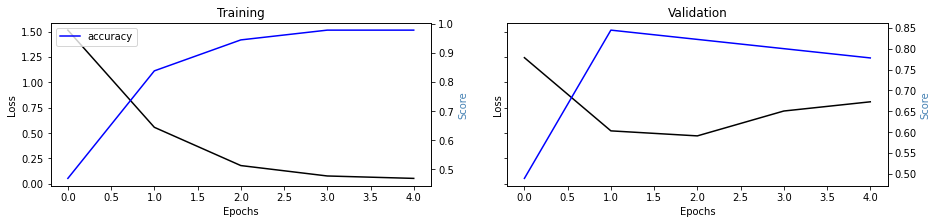

Iteração: 3 Fold: 2 Accuracy: 0.7321428571428571, Mean Accuracy: 0.7857142857142857
Epoch 1/5
23/23 [==============================] - 10s 202ms/step - loss: 1.7496 - accuracy: 0.3971 - val_loss: 1.4199 - val_accuracy: 0.6000
Epoch 2/5
23/23 [==============================] - 4s 157ms/step - loss: 0.7258 - accuracy: 0.8298 - val_loss: 0.8797 - val_accuracy: 0.7556
Epoch 3/5
23/23 [==============================] - 4s 156ms/step - loss: 0.1764 - accuracy: 0.9543 - val_loss: 0.9907 - val_accuracy: 0.7556
Epoch 4/5
23/23 [==============================] - 4s 159ms/step - loss: 0.0316 - accuracy: 0.9938 - val_loss: 1.0058 - val_accuracy: 0.7778
Epoch 5/5
23/23 [==============================] - 4s 160ms/step - loss: 0.0166 - accuracy: 0.9955 - val_loss: 2.1280 - val_accuracy: 0.6444


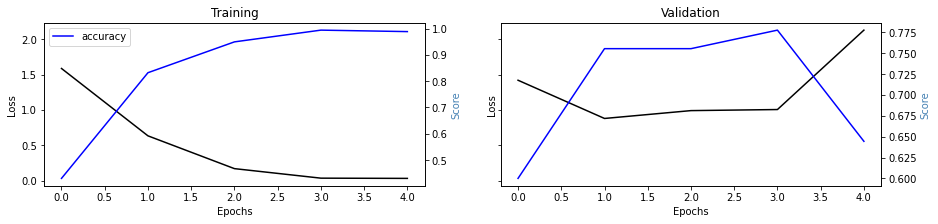

Iteração: 3 Fold: 3 Accuracy: 0.6785714285714286, Mean Accuracy: 0.75
Epoch 1/5
23/23 [==============================] - 10s 205ms/step - loss: 1.7682 - accuracy: 0.3543 - val_loss: 1.3296 - val_accuracy: 0.5111
Epoch 2/5
23/23 [==============================] - 4s 156ms/step - loss: 0.6222 - accuracy: 0.8546 - val_loss: 1.1491 - val_accuracy: 0.7333
Epoch 3/5
23/23 [==============================] - 4s 164ms/step - loss: 0.2543 - accuracy: 0.9036 - val_loss: 0.9406 - val_accuracy: 0.7111
Epoch 4/5
23/23 [==============================] - 4s 164ms/step - loss: 0.0587 - accuracy: 0.9866 - val_loss: 1.1950 - val_accuracy: 0.7556
Epoch 5/5
23/23 [==============================] - 4s 154ms/step - loss: 0.0174 - accuracy: 1.0000 - val_loss: 1.3154 - val_accuracy: 0.7556


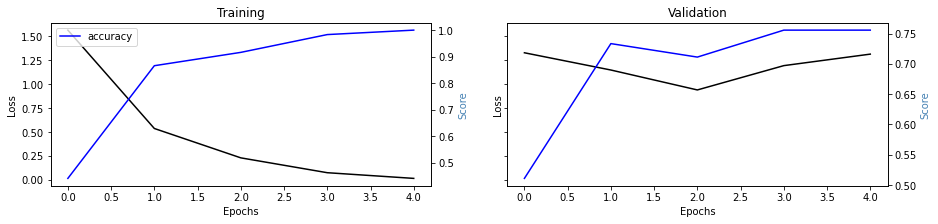

Iteração: 3 Fold: 4 Accuracy: 0.8035714285714286, Mean Accuracy: 0.7633928571428572
Epoch 1/5
23/23 [==============================] - 10s 208ms/step - loss: 1.8110 - accuracy: 0.3084 - val_loss: 1.0034 - val_accuracy: 0.7333
Epoch 2/5
23/23 [==============================] - 4s 156ms/step - loss: 0.6214 - accuracy: 0.8436 - val_loss: 0.7278 - val_accuracy: 0.8444
Epoch 3/5
23/23 [==============================] - 3s 147ms/step - loss: 0.1097 - accuracy: 0.9912 - val_loss: 0.8390 - val_accuracy: 0.8444
Epoch 4/5
23/23 [==============================] - 3s 147ms/step - loss: 0.0595 - accuracy: 0.9871 - val_loss: 0.8726 - val_accuracy: 0.8667
Epoch 5/5
23/23 [==============================] - 4s 154ms/step - loss: 0.0306 - accuracy: 0.9931 - val_loss: 0.8023 - val_accuracy: 0.8444


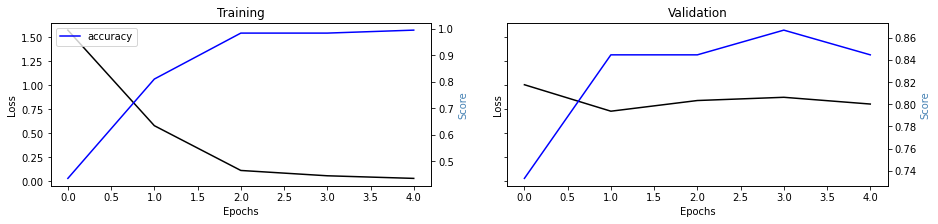

Iteração: 3 Fold: 5 Accuracy: 0.8928571428571429, Mean Accuracy: 0.7892857142857144
Epoch 1/5
23/23 [==============================] - 11s 274ms/step - loss: 1.7795 - accuracy: 0.3026 - val_loss: 1.0813 - val_accuracy: 0.6889
Epoch 2/5
23/23 [==============================] - 4s 158ms/step - loss: 0.6930 - accuracy: 0.8636 - val_loss: 0.7158 - val_accuracy: 0.7556
Epoch 3/5
23/23 [==============================] - 4s 154ms/step - loss: 0.2360 - accuracy: 0.9425 - val_loss: 0.7380 - val_accuracy: 0.8222
Epoch 4/5
23/23 [==============================] - 4s 155ms/step - loss: 0.0602 - accuracy: 0.9887 - val_loss: 0.8926 - val_accuracy: 0.7778
Epoch 5/5
23/23 [==============================] - 4s 159ms/step - loss: 0.0859 - accuracy: 0.9741 - val_loss: 1.0296 - val_accuracy: 0.7556


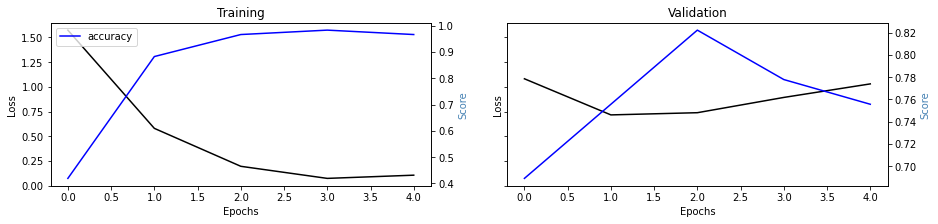

Iteração: 3 Fold: 6 Accuracy: 0.8035714285714286, Mean Accuracy: 0.7916666666666666
Epoch 1/5
23/23 [==============================] - 10s 209ms/step - loss: 1.8145 - accuracy: 0.3062 - val_loss: 1.1092 - val_accuracy: 0.6444
Epoch 2/5
23/23 [==============================] - 4s 174ms/step - loss: 0.6697 - accuracy: 0.7968 - val_loss: 0.5740 - val_accuracy: 0.8000
Epoch 3/5
23/23 [==============================] - 3s 147ms/step - loss: 0.2556 - accuracy: 0.9365 - val_loss: 0.4848 - val_accuracy: 0.8667
Epoch 4/5
23/23 [==============================] - 4s 157ms/step - loss: 0.1164 - accuracy: 0.9654 - val_loss: 0.3602 - val_accuracy: 0.8667
Epoch 5/5
23/23 [==============================] - 4s 165ms/step - loss: 0.0626 - accuracy: 0.9812 - val_loss: 0.3660 - val_accuracy: 0.9111


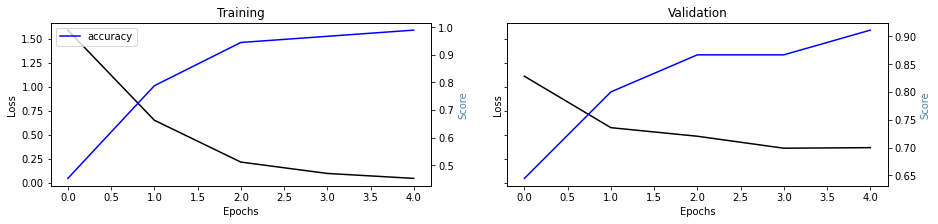

Iteração: 3 Fold: 7 Accuracy: 0.875, Mean Accuracy: 0.8035714285714286
Epoch 1/5
23/23 [==============================] - 10s 198ms/step - loss: 1.7893 - accuracy: 0.2709 - val_loss: 1.1151 - val_accuracy: 0.5556
Epoch 2/5
23/23 [==============================] - 4s 154ms/step - loss: 0.6926 - accuracy: 0.8227 - val_loss: 0.5972 - val_accuracy: 0.7778
Epoch 3/5
23/23 [==============================] - 4s 164ms/step - loss: 0.1528 - accuracy: 0.9724 - val_loss: 0.9731 - val_accuracy: 0.7778
Epoch 4/5
23/23 [==============================] - 4s 151ms/step - loss: 0.0468 - accuracy: 0.9793 - val_loss: 1.3249 - val_accuracy: 0.7333
Epoch 5/5
23/23 [==============================] - 4s 164ms/step - loss: 0.0158 - accuracy: 1.0000 - val_loss: 0.6346 - val_accuracy: 0.8667


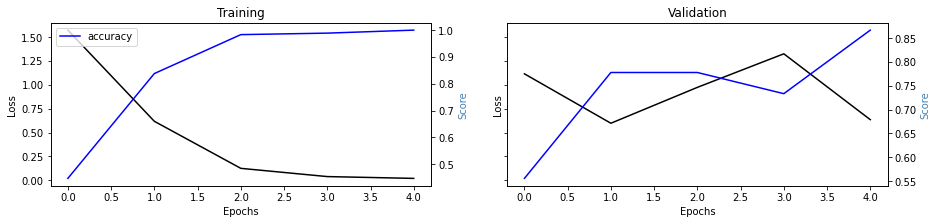

Iteração: 3 Fold: 8 Accuracy: 0.8035714285714286, Mean Accuracy: 0.8035714285714286
Epoch 1/5
23/23 [==============================] - 10s 198ms/step - loss: 1.7545 - accuracy: 0.3256 - val_loss: 0.9117 - val_accuracy: 0.6889
Epoch 2/5
23/23 [==============================] - 4s 161ms/step - loss: 0.6759 - accuracy: 0.7847 - val_loss: 0.4355 - val_accuracy: 0.7778
Epoch 3/5
23/23 [==============================] - 4s 161ms/step - loss: 0.1334 - accuracy: 0.9749 - val_loss: 1.0148 - val_accuracy: 0.6444
Epoch 4/5
23/23 [==============================] - 4s 157ms/step - loss: 0.1376 - accuracy: 0.9502 - val_loss: 0.7155 - val_accuracy: 0.7556
Epoch 5/5
23/23 [==============================] - 4s 160ms/step - loss: 0.0338 - accuracy: 0.9884 - val_loss: 0.5365 - val_accuracy: 0.8444


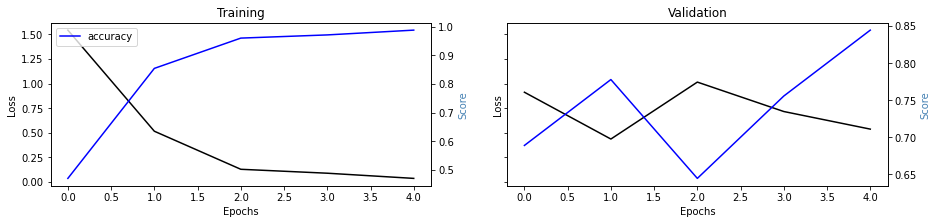

Iteração: 3 Fold: 9 Accuracy: 0.8214285714285714, Mean Accuracy: 0.8055555555555556
Epoch 1/5
23/23 [==============================] - 10s 195ms/step - loss: 1.7562 - accuracy: 0.3259 - val_loss: 1.0425 - val_accuracy: 0.6222
Epoch 2/5
23/23 [==============================] - 3s 151ms/step - loss: 0.6507 - accuracy: 0.7519 - val_loss: 0.9316 - val_accuracy: 0.6889
Epoch 3/5
23/23 [==============================] - 4s 155ms/step - loss: 0.2742 - accuracy: 0.9097 - val_loss: 0.9283 - val_accuracy: 0.6889
Epoch 4/5
23/23 [==============================] - 4s 159ms/step - loss: 0.1036 - accuracy: 0.9830 - val_loss: 0.6749 - val_accuracy: 0.8222
Epoch 5/5
23/23 [==============================] - 4s 156ms/step - loss: 0.0418 - accuracy: 1.0000 - val_loss: 0.6096 - val_accuracy: 0.8667


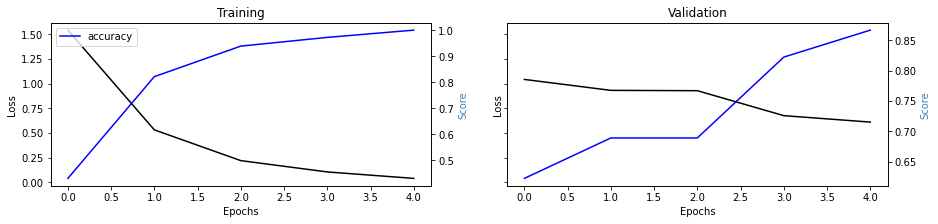

Iteração: 3 Fold: 10 Accuracy: 0.8035714285714286, Mean Accuracy: 0.8053571428571429
Epoch 1/5
23/23 [==============================] - 10s 205ms/step - loss: 1.8013 - accuracy: 0.3220 - val_loss: 1.2933 - val_accuracy: 0.5778
Epoch 2/5
23/23 [==============================] - 4s 173ms/step - loss: 0.7097 - accuracy: 0.7998 - val_loss: 0.8347 - val_accuracy: 0.8000
Epoch 3/5
23/23 [==============================] - 4s 167ms/step - loss: 0.3263 - accuracy: 0.8878 - val_loss: 0.6794 - val_accuracy: 0.7778
Epoch 4/5
23/23 [==============================] - 4s 157ms/step - loss: 0.1066 - accuracy: 0.9864 - val_loss: 0.6608 - val_accuracy: 0.8000
Epoch 5/5
23/23 [==============================] - 4s 155ms/step - loss: 0.0205 - accuracy: 0.9965 - val_loss: 0.6513 - val_accuracy: 0.8222


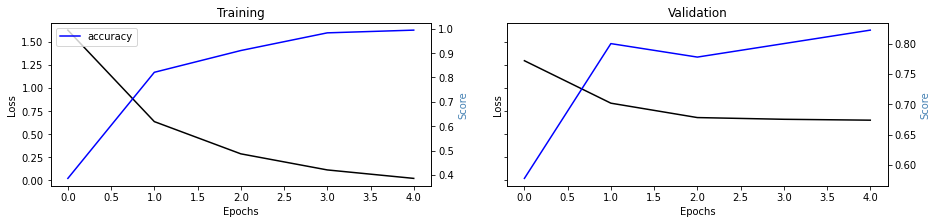

Iteração: 4 Fold: 1 Accuracy: 0.8392857142857143, Mean Accuracy: 0.8392857142857143
Epoch 1/5
23/23 [==============================] - 10s 210ms/step - loss: 1.8049 - accuracy: 0.2246 - val_loss: 1.1979 - val_accuracy: 0.6444
Epoch 2/5
23/23 [==============================] - 4s 162ms/step - loss: 0.6698 - accuracy: 0.8076 - val_loss: 0.5291 - val_accuracy: 0.8222
Epoch 3/5
23/23 [==============================] - 4s 167ms/step - loss: 0.2491 - accuracy: 0.9247 - val_loss: 0.5046 - val_accuracy: 0.8444
Epoch 4/5
23/23 [==============================] - 4s 160ms/step - loss: 0.0804 - accuracy: 0.9816 - val_loss: 0.6993 - val_accuracy: 0.8222
Epoch 5/5
23/23 [==============================] - 4s 159ms/step - loss: 0.0253 - accuracy: 0.9912 - val_loss: 0.4143 - val_accuracy: 0.8667


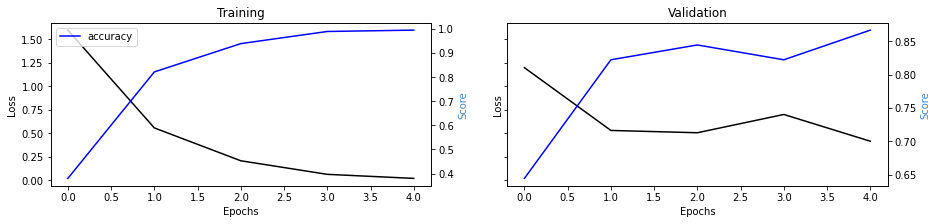

Iteração: 4 Fold: 2 Accuracy: 0.8214285714285714, Mean Accuracy: 0.8303571428571428
Epoch 1/5
23/23 [==============================] - 10s 201ms/step - loss: 1.7695 - accuracy: 0.2909 - val_loss: 1.0215 - val_accuracy: 0.7333
Epoch 2/5
23/23 [==============================] - 4s 160ms/step - loss: 0.6240 - accuracy: 0.8473 - val_loss: 0.7983 - val_accuracy: 0.7556
Epoch 3/5
23/23 [==============================] - 3s 149ms/step - loss: 0.1916 - accuracy: 0.9334 - val_loss: 0.5654 - val_accuracy: 0.8000
Epoch 4/5
23/23 [==============================] - 4s 160ms/step - loss: 0.0898 - accuracy: 0.9739 - val_loss: 0.7128 - val_accuracy: 0.7778
Epoch 5/5
23/23 [==============================] - 4s 155ms/step - loss: 0.0346 - accuracy: 0.9872 - val_loss: 0.7972 - val_accuracy: 0.7778


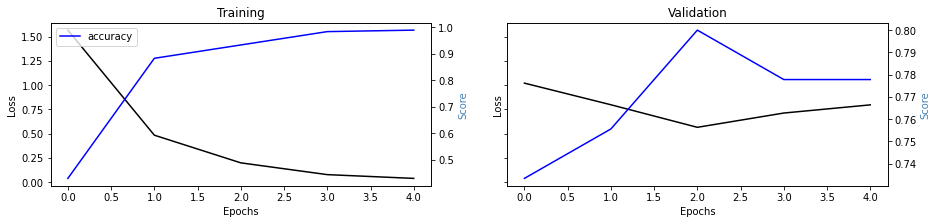

Iteração: 4 Fold: 3 Accuracy: 0.8035714285714286, Mean Accuracy: 0.8214285714285715
Epoch 1/5
23/23 [==============================] - 10s 207ms/step - loss: 1.8759 - accuracy: 0.3196 - val_loss: 1.1451 - val_accuracy: 0.6889
Epoch 2/5
23/23 [==============================] - 4s 160ms/step - loss: 0.6717 - accuracy: 0.8198 - val_loss: 0.9036 - val_accuracy: 0.7556
Epoch 3/5
23/23 [==============================] - 4s 164ms/step - loss: 0.2139 - accuracy: 0.9196 - val_loss: 1.1957 - val_accuracy: 0.7111
Epoch 4/5
23/23 [==============================] - 4s 163ms/step - loss: 0.1095 - accuracy: 0.9643 - val_loss: 0.8539 - val_accuracy: 0.8000
Epoch 5/5
23/23 [==============================] - 4s 168ms/step - loss: 0.0927 - accuracy: 0.9650 - val_loss: 1.2605 - val_accuracy: 0.7556


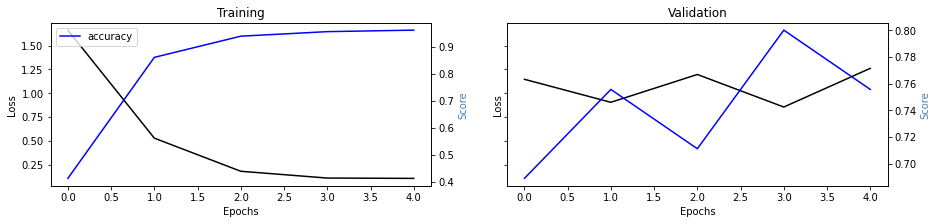

Iteração: 4 Fold: 4 Accuracy: 0.7857142857142857, Mean Accuracy: 0.8125
Epoch 1/5
23/23 [==============================] - 12s 203ms/step - loss: 1.8388 - accuracy: 0.2953 - val_loss: 1.0154 - val_accuracy: 0.7556
Epoch 2/5
23/23 [==============================] - 4s 161ms/step - loss: 0.7394 - accuracy: 0.7906 - val_loss: 0.6520 - val_accuracy: 0.8444
Epoch 3/5
23/23 [==============================] - 4s 158ms/step - loss: 0.2186 - accuracy: 0.9269 - val_loss: 0.6341 - val_accuracy: 0.8444
Epoch 4/5
23/23 [==============================] - 4s 180ms/step - loss: 0.0203 - accuracy: 1.0000 - val_loss: 0.8266 - val_accuracy: 0.8222
Epoch 5/5
23/23 [==============================] - 4s 156ms/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.8683 - val_accuracy: 0.8222


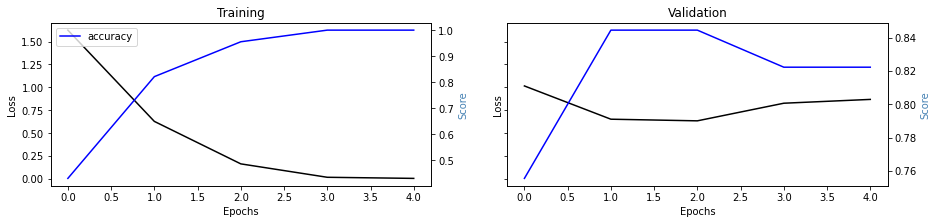

Iteração: 4 Fold: 5 Accuracy: 0.9107142857142857, Mean Accuracy: 0.8321428571428571
Epoch 1/5
23/23 [==============================] - 10s 201ms/step - loss: 1.7553 - accuracy: 0.3660 - val_loss: 1.1422 - val_accuracy: 0.5111
Epoch 2/5
23/23 [==============================] - 4s 163ms/step - loss: 0.6347 - accuracy: 0.7896 - val_loss: 0.6341 - val_accuracy: 0.7778
Epoch 3/5
23/23 [==============================] - 4s 163ms/step - loss: 0.1595 - accuracy: 0.9492 - val_loss: 0.7537 - val_accuracy: 0.7333
Epoch 4/5
23/23 [==============================] - 4s 173ms/step - loss: 0.0674 - accuracy: 0.9743 - val_loss: 0.8347 - val_accuracy: 0.6889
Epoch 5/5
23/23 [==============================] - 4s 167ms/step - loss: 0.0874 - accuracy: 0.9554 - val_loss: 0.7780 - val_accuracy: 0.7778


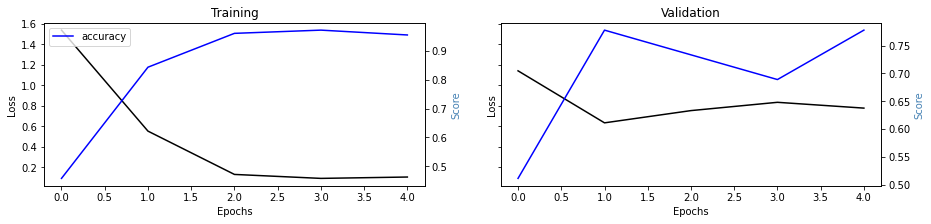

Iteração: 4 Fold: 6 Accuracy: 0.8571428571428571, Mean Accuracy: 0.8363095238095237
Epoch 1/5
23/23 [==============================] - 10s 208ms/step - loss: 1.7418 - accuracy: 0.2885 - val_loss: 1.1512 - val_accuracy: 0.6444
Epoch 2/5
23/23 [==============================] - 4s 180ms/step - loss: 0.7553 - accuracy: 0.8145 - val_loss: 0.4748 - val_accuracy: 0.9111
Epoch 3/5
23/23 [==============================] - 4s 162ms/step - loss: 0.1871 - accuracy: 0.9584 - val_loss: 0.3685 - val_accuracy: 0.8889
Epoch 4/5
23/23 [==============================] - 4s 156ms/step - loss: 0.1561 - accuracy: 0.9624 - val_loss: 0.4905 - val_accuracy: 0.8444
Epoch 5/5
23/23 [==============================] - 4s 158ms/step - loss: 0.0783 - accuracy: 0.9695 - val_loss: 0.2772 - val_accuracy: 0.9333


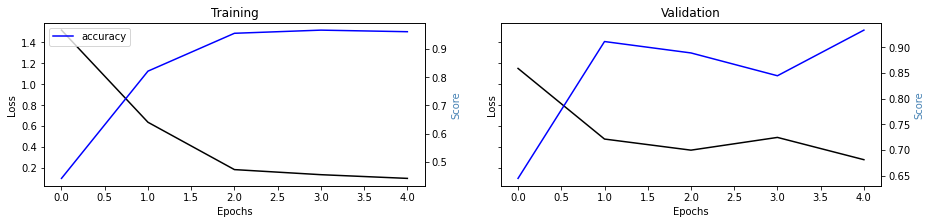

Iteração: 4 Fold: 7 Accuracy: 0.875, Mean Accuracy: 0.8418367346938774
Epoch 1/5
23/23 [==============================] - 10s 203ms/step - loss: 1.8242 - accuracy: 0.2662 - val_loss: 1.0648 - val_accuracy: 0.8000
Epoch 2/5
23/23 [==============================] - 4s 170ms/step - loss: 0.6777 - accuracy: 0.9062 - val_loss: 0.6745 - val_accuracy: 0.7333
Epoch 3/5
23/23 [==============================] - 4s 154ms/step - loss: 0.1743 - accuracy: 0.9618 - val_loss: 0.7238 - val_accuracy: 0.7778
Epoch 4/5
23/23 [==============================] - 4s 154ms/step - loss: 0.0827 - accuracy: 0.9847 - val_loss: 0.6534 - val_accuracy: 0.8222
Epoch 5/5
23/23 [==============================] - 4s 164ms/step - loss: 0.0352 - accuracy: 0.9938 - val_loss: 0.7712 - val_accuracy: 0.7778


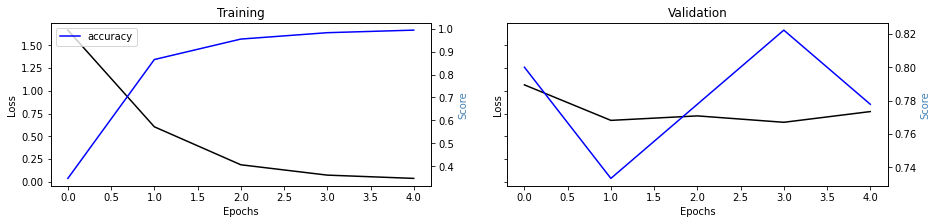

Iteração: 4 Fold: 8 Accuracy: 0.75, Mean Accuracy: 0.8303571428571428
Epoch 1/5
23/23 [==============================] - 12s 209ms/step - loss: 1.7975 - accuracy: 0.3014 - val_loss: 1.0423 - val_accuracy: 0.6444
Epoch 2/5
23/23 [==============================] - 4s 156ms/step - loss: 0.6206 - accuracy: 0.8624 - val_loss: 0.6284 - val_accuracy: 0.8000
Epoch 3/5
23/23 [==============================] - 4s 159ms/step - loss: 0.1574 - accuracy: 0.9482 - val_loss: 0.7017 - val_accuracy: 0.7556
Epoch 4/5
23/23 [==============================] - 4s 160ms/step - loss: 0.0743 - accuracy: 0.9757 - val_loss: 0.9938 - val_accuracy: 0.7333
Epoch 5/5
23/23 [==============================] - 4s 171ms/step - loss: 0.0504 - accuracy: 0.9850 - val_loss: 0.8953 - val_accuracy: 0.7333


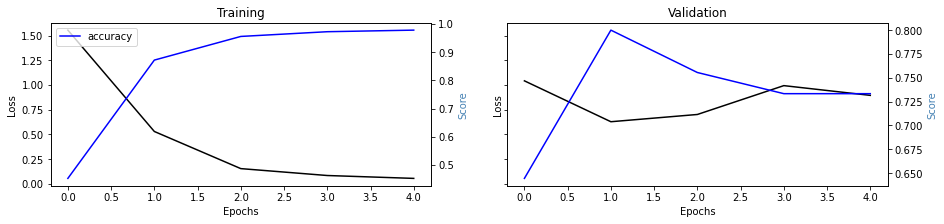

Iteração: 4 Fold: 9 Accuracy: 0.8035714285714286, Mean Accuracy: 0.8273809523809523
Epoch 1/5
23/23 [==============================] - 10s 211ms/step - loss: 1.7946 - accuracy: 0.2927 - val_loss: 1.1707 - val_accuracy: 0.6222
Epoch 2/5
23/23 [==============================] - 4s 179ms/step - loss: 0.7222 - accuracy: 0.8261 - val_loss: 0.9178 - val_accuracy: 0.7556
Epoch 3/5
23/23 [==============================] - 4s 169ms/step - loss: 0.2113 - accuracy: 0.9400 - val_loss: 0.5315 - val_accuracy: 0.8667
Epoch 4/5
23/23 [==============================] - 4s 173ms/step - loss: 0.0550 - accuracy: 0.9818 - val_loss: 0.8979 - val_accuracy: 0.7778
Epoch 5/5
23/23 [==============================] - 4s 158ms/step - loss: 0.0344 - accuracy: 0.9913 - val_loss: 0.5781 - val_accuracy: 0.8222


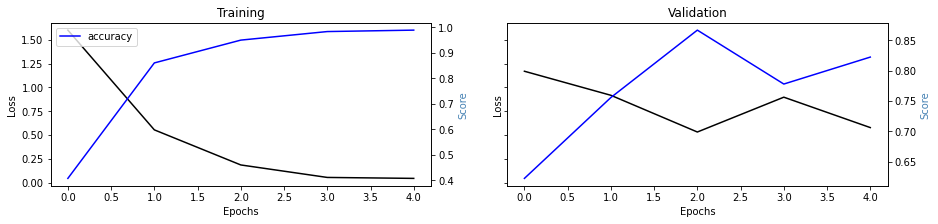

Iteração: 4 Fold: 10 Accuracy: 0.875, Mean Accuracy: 0.8321428571428571
Epoch 1/5
23/23 [==============================] - 10s 201ms/step - loss: 1.8300 - accuracy: 0.3450 - val_loss: 1.2301 - val_accuracy: 0.6000
Epoch 2/5
23/23 [==============================] - 4s 174ms/step - loss: 0.6901 - accuracy: 0.8302 - val_loss: 0.7144 - val_accuracy: 0.7556
Epoch 3/5
23/23 [==============================] - 4s 177ms/step - loss: 0.2568 - accuracy: 0.9167 - val_loss: 0.6715 - val_accuracy: 0.7778
Epoch 4/5
23/23 [==============================] - 4s 173ms/step - loss: 0.1675 - accuracy: 0.9334 - val_loss: 0.8141 - val_accuracy: 0.7778
Epoch 5/5
23/23 [==============================] - 4s 171ms/step - loss: 0.0736 - accuracy: 0.9693 - val_loss: 0.6493 - val_accuracy: 0.8222


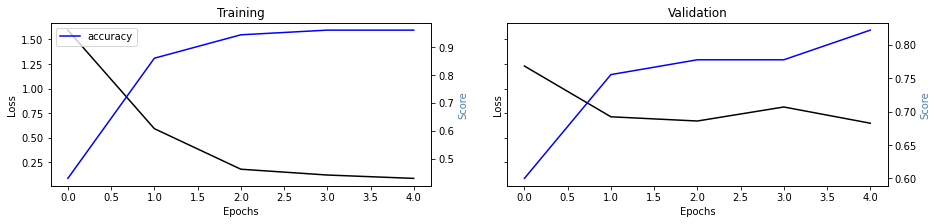

Iteração: 5 Fold: 1 Accuracy: 0.75, Mean Accuracy: 0.75
Epoch 1/5
23/23 [==============================] - 10s 198ms/step - loss: 1.8292 - accuracy: 0.2515 - val_loss: 1.0803 - val_accuracy: 0.5778
Epoch 2/5
23/23 [==============================] - 4s 176ms/step - loss: 0.6551 - accuracy: 0.8329 - val_loss: 0.5326 - val_accuracy: 0.8222
Epoch 3/5
23/23 [==============================] - 4s 171ms/step - loss: 0.1696 - accuracy: 0.9702 - val_loss: 0.6746 - val_accuracy: 0.7556
Epoch 4/5
23/23 [==============================] - 4s 174ms/step - loss: 0.0691 - accuracy: 0.9725 - val_loss: 0.5604 - val_accuracy: 0.8444
Epoch 5/5
23/23 [==============================] - 4s 172ms/step - loss: 0.0462 - accuracy: 0.9952 - val_loss: 0.6559 - val_accuracy: 0.8000


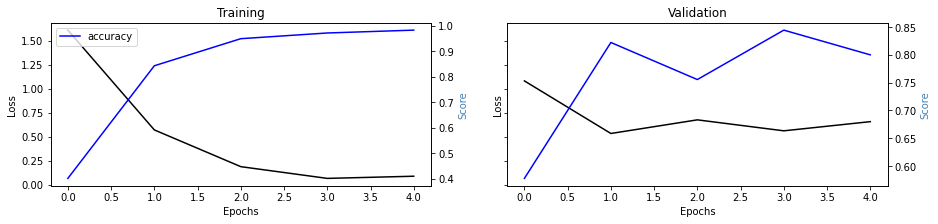

Iteração: 5 Fold: 2 Accuracy: 0.6964285714285714, Mean Accuracy: 0.7232142857142857
Epoch 1/5
23/23 [==============================] - 12s 293ms/step - loss: 1.8157 - accuracy: 0.2570 - val_loss: 1.1887 - val_accuracy: 0.7111
Epoch 2/5
23/23 [==============================] - 4s 168ms/step - loss: 0.7208 - accuracy: 0.8484 - val_loss: 0.9575 - val_accuracy: 0.7333
Epoch 3/5
23/23 [==============================] - 4s 171ms/step - loss: 0.1345 - accuracy: 0.9894 - val_loss: 0.9305 - val_accuracy: 0.8000
Epoch 4/5
23/23 [==============================] - 4s 163ms/step - loss: 0.0334 - accuracy: 0.9995 - val_loss: 1.0901 - val_accuracy: 0.7556
Epoch 5/5
23/23 [==============================] - 4s 166ms/step - loss: 0.0500 - accuracy: 0.9878 - val_loss: 0.7508 - val_accuracy: 0.8222


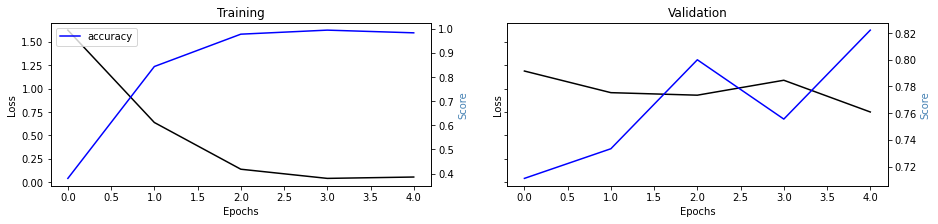

Iteração: 5 Fold: 3 Accuracy: 0.9285714285714286, Mean Accuracy: 0.7916666666666666
Epoch 1/5
23/23 [==============================] - 10s 205ms/step - loss: 1.7987 - accuracy: 0.3460 - val_loss: 1.1751 - val_accuracy: 0.6667
Epoch 2/5
23/23 [==============================] - 4s 178ms/step - loss: 0.7451 - accuracy: 0.8018 - val_loss: 0.9000 - val_accuracy: 0.7778
Epoch 3/5
23/23 [==============================] - 4s 174ms/step - loss: 0.2332 - accuracy: 0.9123 - val_loss: 1.0927 - val_accuracy: 0.7333
Epoch 4/5
23/23 [==============================] - 4s 171ms/step - loss: 0.2571 - accuracy: 0.9075 - val_loss: 0.8580 - val_accuracy: 0.8000
Epoch 5/5
23/23 [==============================] - 4s 172ms/step - loss: 0.0667 - accuracy: 0.9772 - val_loss: 0.8498 - val_accuracy: 0.8222


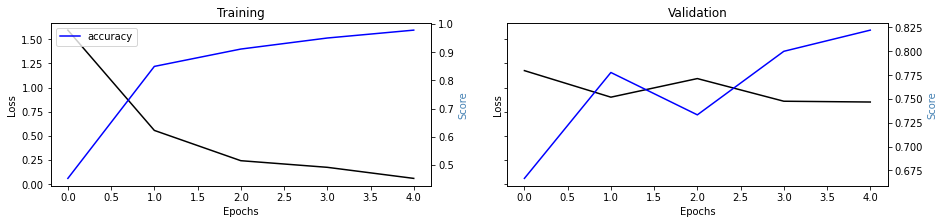

Iteração: 5 Fold: 4 Accuracy: 0.8214285714285714, Mean Accuracy: 0.7991071428571428
Epoch 1/5
23/23 [==============================] - 10s 213ms/step - loss: 1.7676 - accuracy: 0.3133 - val_loss: 1.0560 - val_accuracy: 0.6444
Epoch 2/5
23/23 [==============================] - 4s 160ms/step - loss: 0.7713 - accuracy: 0.7673 - val_loss: 0.6944 - val_accuracy: 0.8222
Epoch 3/5
23/23 [==============================] - 4s 159ms/step - loss: 0.1720 - accuracy: 0.9746 - val_loss: 0.6736 - val_accuracy: 0.8222
Epoch 4/5
23/23 [==============================] - 4s 170ms/step - loss: 0.1858 - accuracy: 0.9494 - val_loss: 0.7073 - val_accuracy: 0.8444
Epoch 5/5
23/23 [==============================] - 4s 172ms/step - loss: 0.0384 - accuracy: 1.0000 - val_loss: 0.5543 - val_accuracy: 0.8667


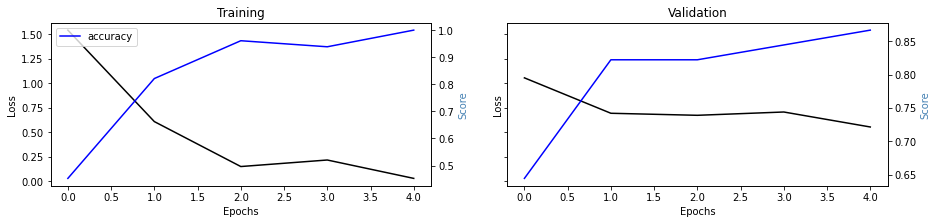

Iteração: 5 Fold: 5 Accuracy: 0.8571428571428571, Mean Accuracy: 0.8107142857142856
Epoch 1/5
23/23 [==============================] - 10s 222ms/step - loss: 1.7452 - accuracy: 0.3897 - val_loss: 0.8952 - val_accuracy: 0.7111
Epoch 2/5
23/23 [==============================] - 4s 168ms/step - loss: 0.6396 - accuracy: 0.8560 - val_loss: 0.6744 - val_accuracy: 0.8000
Epoch 3/5
23/23 [==============================] - 4s 169ms/step - loss: 0.2121 - accuracy: 0.9468 - val_loss: 0.5129 - val_accuracy: 0.7333
Epoch 4/5
23/23 [==============================] - 4s 188ms/step - loss: 0.1046 - accuracy: 0.9658 - val_loss: 0.5768 - val_accuracy: 0.8444
Epoch 5/5
23/23 [==============================] - 4s 151ms/step - loss: 0.0347 - accuracy: 0.9895 - val_loss: 0.5007 - val_accuracy: 0.8000


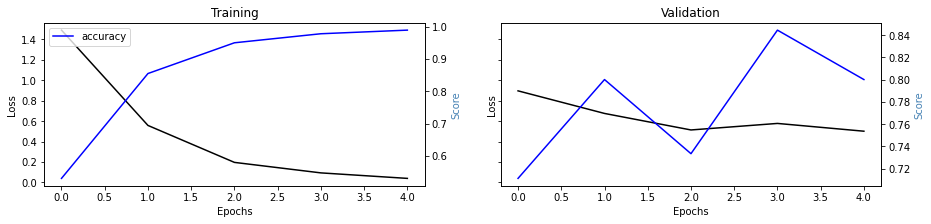

Iteração: 5 Fold: 6 Accuracy: 0.8571428571428571, Mean Accuracy: 0.8184523809523808
Epoch 1/5
23/23 [==============================] - 10s 212ms/step - loss: 1.7671 - accuracy: 0.3294 - val_loss: 1.0813 - val_accuracy: 0.6889
Epoch 2/5
23/23 [==============================] - 4s 170ms/step - loss: 0.7061 - accuracy: 0.8504 - val_loss: 0.5538 - val_accuracy: 0.8222
Epoch 3/5
23/23 [==============================] - 4s 156ms/step - loss: 0.1722 - accuracy: 0.9553 - val_loss: 0.6555 - val_accuracy: 0.8444
Epoch 4/5
23/23 [==============================] - 4s 162ms/step - loss: 0.1406 - accuracy: 0.9592 - val_loss: 0.3607 - val_accuracy: 0.8889
Epoch 5/5
23/23 [==============================] - 4s 156ms/step - loss: 0.1576 - accuracy: 0.9700 - val_loss: 0.4727 - val_accuracy: 0.9111


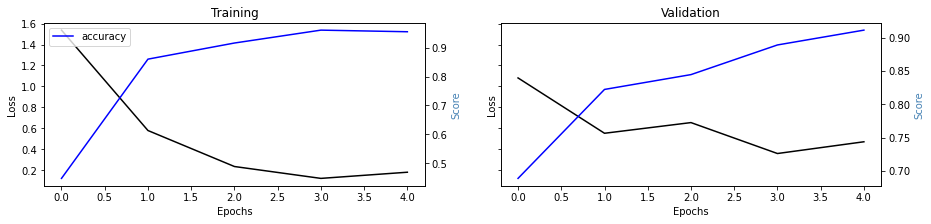

Iteração: 5 Fold: 7 Accuracy: 0.8571428571428571, Mean Accuracy: 0.8239795918367345
Epoch 1/5
23/23 [==============================] - 10s 221ms/step - loss: 1.7830 - accuracy: 0.3228 - val_loss: 1.0835 - val_accuracy: 0.6444
Epoch 2/5
23/23 [==============================] - 4s 162ms/step - loss: 0.6789 - accuracy: 0.8182 - val_loss: 1.0153 - val_accuracy: 0.6222
Epoch 3/5
23/23 [==============================] - 4s 173ms/step - loss: 0.3234 - accuracy: 0.9176 - val_loss: 0.5718 - val_accuracy: 0.7778
Epoch 4/5
23/23 [==============================] - 4s 161ms/step - loss: 0.0696 - accuracy: 0.9913 - val_loss: 0.8790 - val_accuracy: 0.7556
Epoch 5/5
23/23 [==============================] - 4s 162ms/step - loss: 0.0466 - accuracy: 0.9968 - val_loss: 0.8557 - val_accuracy: 0.8000


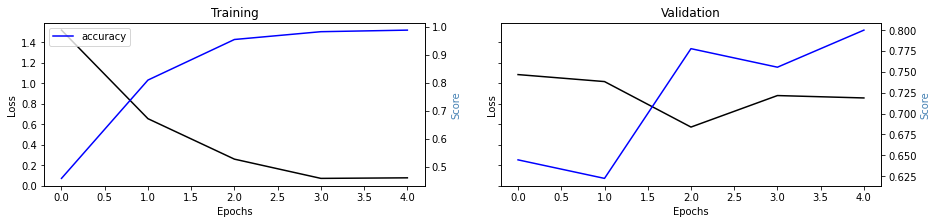

Iteração: 5 Fold: 8 Accuracy: 0.8392857142857143, Mean Accuracy: 0.825892857142857
Epoch 1/5
23/23 [==============================] - 10s 205ms/step - loss: 1.7756 - accuracy: 0.2746 - val_loss: 0.9854 - val_accuracy: 0.8000
Epoch 2/5
23/23 [==============================] - 4s 178ms/step - loss: 0.7116 - accuracy: 0.8006 - val_loss: 1.0189 - val_accuracy: 0.6667
Epoch 3/5
23/23 [==============================] - 4s 177ms/step - loss: 0.3749 - accuracy: 0.8808 - val_loss: 0.5813 - val_accuracy: 0.8222
Epoch 4/5
23/23 [==============================] - 4s 166ms/step - loss: 0.0909 - accuracy: 0.9754 - val_loss: 1.3871 - val_accuracy: 0.6222
Epoch 5/5
23/23 [==============================] - 4s 159ms/step - loss: 0.0437 - accuracy: 0.9979 - val_loss: 0.5999 - val_accuracy: 0.7333


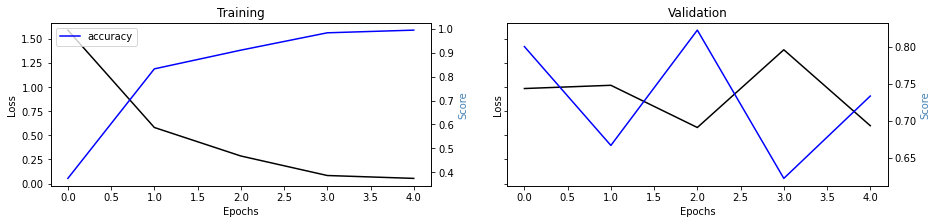

Iteração: 5 Fold: 9 Accuracy: 0.8214285714285714, Mean Accuracy: 0.8253968253968252
Epoch 1/5
23/23 [==============================] - 10s 198ms/step - loss: 1.7666 - accuracy: 0.3686 - val_loss: 1.2424 - val_accuracy: 0.5333
Epoch 2/5
23/23 [==============================] - 4s 161ms/step - loss: 0.7015 - accuracy: 0.8298 - val_loss: 0.8316 - val_accuracy: 0.7556
Epoch 3/5
23/23 [==============================] - 4s 174ms/step - loss: 0.1637 - accuracy: 0.9652 - val_loss: 0.7406 - val_accuracy: 0.8667
Epoch 4/5
23/23 [==============================] - 4s 175ms/step - loss: 0.1011 - accuracy: 0.9670 - val_loss: 0.7804 - val_accuracy: 0.7778
Epoch 5/5
23/23 [==============================] - 4s 171ms/step - loss: 0.0451 - accuracy: 0.9899 - val_loss: 0.9450 - val_accuracy: 0.7556


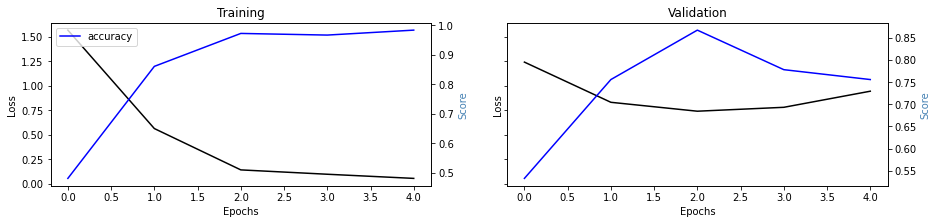

Iteração: 5 Fold: 10 Accuracy: 0.8214285714285714, Mean Accuracy: 0.8249999999999998
Epoch 1/5
23/23 [==============================] - 10s 202ms/step - loss: 1.8177 - accuracy: 0.2145 - val_loss: 1.1253 - val_accuracy: 0.7556
Epoch 2/5
23/23 [==============================] - 4s 156ms/step - loss: 0.6778 - accuracy: 0.8790 - val_loss: 0.7971 - val_accuracy: 0.8000
Epoch 3/5
23/23 [==============================] - 4s 157ms/step - loss: 0.2686 - accuracy: 0.9308 - val_loss: 0.8194 - val_accuracy: 0.8444
Epoch 4/5
23/23 [==============================] - 4s 172ms/step - loss: 0.1235 - accuracy: 0.9693 - val_loss: 0.8044 - val_accuracy: 0.8444
Epoch 5/5
23/23 [==============================] - 4s 166ms/step - loss: 0.0273 - accuracy: 1.0000 - val_loss: 0.8147 - val_accuracy: 0.8222


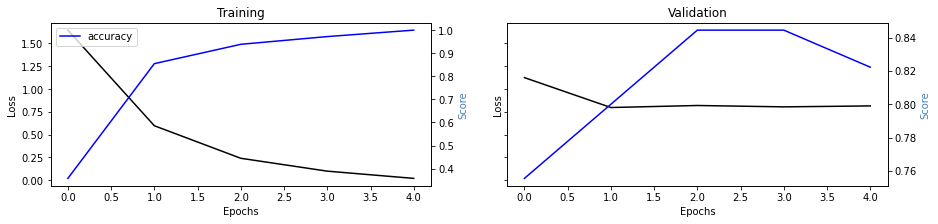

Iteração: 6 Fold: 1 Accuracy: 0.8214285714285714, Mean Accuracy: 0.8214285714285714
Epoch 1/5
23/23 [==============================] - 12s 214ms/step - loss: 1.7371 - accuracy: 0.3615 - val_loss: 1.0558 - val_accuracy: 0.6222
Epoch 2/5
23/23 [==============================] - 4s 177ms/step - loss: 0.6359 - accuracy: 0.8651 - val_loss: 0.7882 - val_accuracy: 0.7778
Epoch 3/5
23/23 [==============================] - 4s 174ms/step - loss: 0.1898 - accuracy: 0.9413 - val_loss: 0.5604 - val_accuracy: 0.8222
Epoch 4/5
23/23 [==============================] - 4s 177ms/step - loss: 0.0478 - accuracy: 0.9990 - val_loss: 0.7507 - val_accuracy: 0.8000
Epoch 5/5
23/23 [==============================] - 4s 167ms/step - loss: 0.0269 - accuracy: 0.9988 - val_loss: 0.7316 - val_accuracy: 0.8000


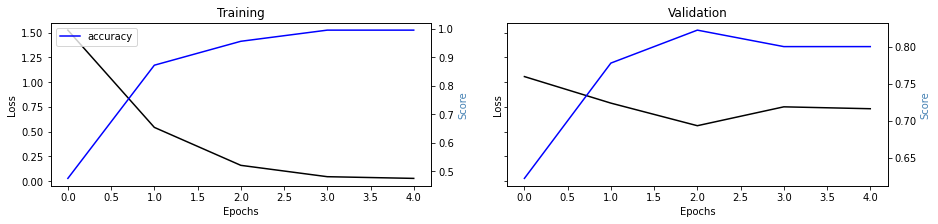

Iteração: 6 Fold: 2 Accuracy: 0.7857142857142857, Mean Accuracy: 0.8035714285714286
Epoch 1/5
23/23 [==============================] - 10s 216ms/step - loss: 1.8073 - accuracy: 0.3394 - val_loss: 1.0694 - val_accuracy: 0.7778
Epoch 2/5
23/23 [==============================] - 4s 179ms/step - loss: 0.7930 - accuracy: 0.8070 - val_loss: 0.8659 - val_accuracy: 0.7333
Epoch 3/5
23/23 [==============================] - 4s 171ms/step - loss: 0.2385 - accuracy: 0.9292 - val_loss: 0.7338 - val_accuracy: 0.8000
Epoch 4/5
23/23 [==============================] - 4s 183ms/step - loss: 0.0669 - accuracy: 0.9707 - val_loss: 0.7254 - val_accuracy: 0.8000
Epoch 5/5
23/23 [==============================] - 4s 178ms/step - loss: 0.0901 - accuracy: 0.9816 - val_loss: 0.9043 - val_accuracy: 0.7778


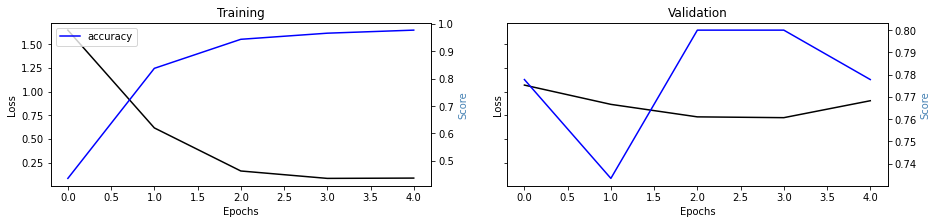

Iteração: 6 Fold: 3 Accuracy: 0.8035714285714286, Mean Accuracy: 0.8035714285714285
Epoch 1/5
23/23 [==============================] - 10s 222ms/step - loss: 1.7555 - accuracy: 0.3252 - val_loss: 1.2495 - val_accuracy: 0.6444
Epoch 2/5
23/23 [==============================] - 4s 175ms/step - loss: 0.6161 - accuracy: 0.8657 - val_loss: 1.1352 - val_accuracy: 0.5778
Epoch 3/5
23/23 [==============================] - 4s 159ms/step - loss: 0.3292 - accuracy: 0.8878 - val_loss: 1.1002 - val_accuracy: 0.7556
Epoch 4/5
23/23 [==============================] - 4s 176ms/step - loss: 0.0562 - accuracy: 0.9844 - val_loss: 1.0859 - val_accuracy: 0.7778
Epoch 5/5
23/23 [==============================] - 4s 181ms/step - loss: 0.0343 - accuracy: 0.9858 - val_loss: 1.0133 - val_accuracy: 0.8000


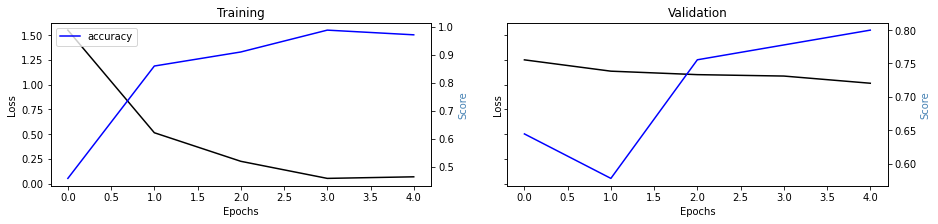

Iteração: 6 Fold: 4 Accuracy: 0.8214285714285714, Mean Accuracy: 0.8080357142857142
Epoch 1/5
23/23 [==============================] - 10s 225ms/step - loss: 1.8429 - accuracy: 0.2510 - val_loss: 1.1636 - val_accuracy: 0.6000
Epoch 2/5
23/23 [==============================] - 4s 167ms/step - loss: 0.6691 - accuracy: 0.8089 - val_loss: 0.6957 - val_accuracy: 0.8444
Epoch 3/5
23/23 [==============================] - 4s 171ms/step - loss: 0.2078 - accuracy: 0.9377 - val_loss: 0.6805 - val_accuracy: 0.8222
Epoch 4/5
23/23 [==============================] - 4s 178ms/step - loss: 0.0554 - accuracy: 0.9731 - val_loss: 0.8658 - val_accuracy: 0.8000
Epoch 5/5
23/23 [==============================] - 4s 180ms/step - loss: 0.1382 - accuracy: 0.9627 - val_loss: 0.7317 - val_accuracy: 0.8667


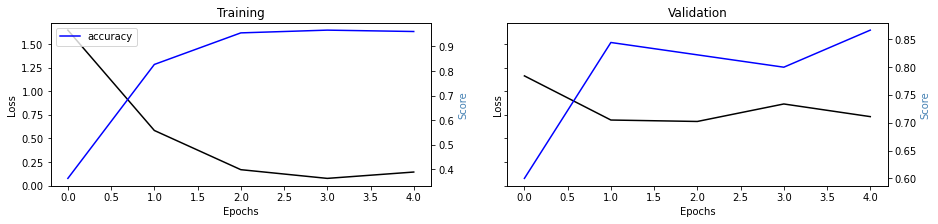

Iteração: 6 Fold: 5 Accuracy: 0.8035714285714286, Mean Accuracy: 0.8071428571428572
Epoch 1/5
23/23 [==============================] - 12s 208ms/step - loss: 1.8480 - accuracy: 0.3256 - val_loss: 1.1389 - val_accuracy: 0.6000
Epoch 2/5
23/23 [==============================] - 4s 170ms/step - loss: 0.6776 - accuracy: 0.8311 - val_loss: 0.5861 - val_accuracy: 0.8000
Epoch 3/5
23/23 [==============================] - 4s 164ms/step - loss: 0.2093 - accuracy: 0.9606 - val_loss: 0.6841 - val_accuracy: 0.8000
Epoch 4/5
23/23 [==============================] - 4s 170ms/step - loss: 0.1679 - accuracy: 0.9354 - val_loss: 0.4868 - val_accuracy: 0.8889
Epoch 5/5
23/23 [==============================] - 4s 197ms/step - loss: 0.0278 - accuracy: 1.0000 - val_loss: 0.5899 - val_accuracy: 0.8000


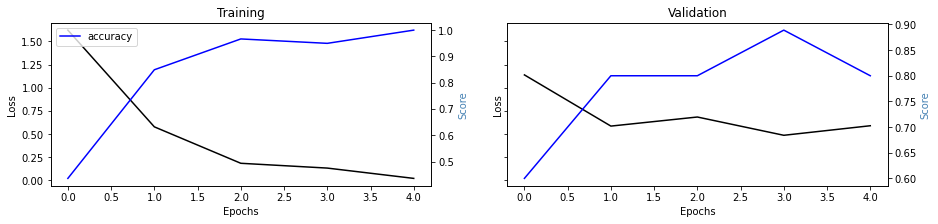

Iteração: 6 Fold: 6 Accuracy: 0.8571428571428571, Mean Accuracy: 0.8154761904761904
Epoch 1/5
23/23 [==============================] - 10s 222ms/step - loss: 1.8037 - accuracy: 0.2848 - val_loss: 1.0407 - val_accuracy: 0.6889
Epoch 2/5
23/23 [==============================] - 4s 164ms/step - loss: 0.6991 - accuracy: 0.7963 - val_loss: 0.7605 - val_accuracy: 0.7111
Epoch 3/5
23/23 [==============================] - 4s 176ms/step - loss: 0.3161 - accuracy: 0.8556 - val_loss: 0.5274 - val_accuracy: 0.8000
Epoch 4/5
23/23 [==============================] - 4s 170ms/step - loss: 0.1364 - accuracy: 0.9559 - val_loss: 0.4772 - val_accuracy: 0.8889
Epoch 5/5
23/23 [==============================] - 4s 178ms/step - loss: 0.0533 - accuracy: 0.9929 - val_loss: 0.4305 - val_accuracy: 0.8667


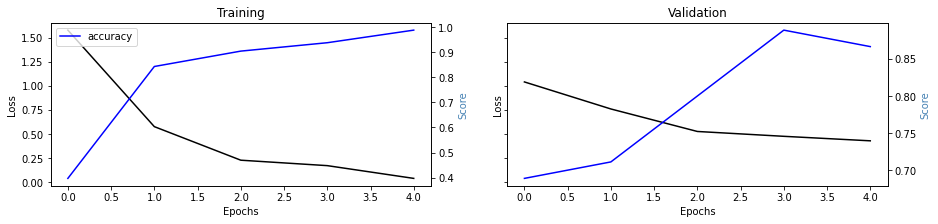

Iteração: 6 Fold: 7 Accuracy: 0.8571428571428571, Mean Accuracy: 0.8214285714285713
Epoch 1/5
23/23 [==============================] - 10s 224ms/step - loss: 1.7531 - accuracy: 0.3299 - val_loss: 1.0120 - val_accuracy: 0.6667
Epoch 2/5
23/23 [==============================] - 4s 163ms/step - loss: 0.6047 - accuracy: 0.8693 - val_loss: 0.7063 - val_accuracy: 0.6889
Epoch 3/5
23/23 [==============================] - 4s 176ms/step - loss: 0.1573 - accuracy: 0.9695 - val_loss: 1.0171 - val_accuracy: 0.7111
Epoch 4/5
23/23 [==============================] - 4s 164ms/step - loss: 0.1343 - accuracy: 0.9645 - val_loss: 0.6077 - val_accuracy: 0.8667
Epoch 5/5
23/23 [==============================] - 4s 168ms/step - loss: 0.0203 - accuracy: 0.9993 - val_loss: 0.6670 - val_accuracy: 0.8222


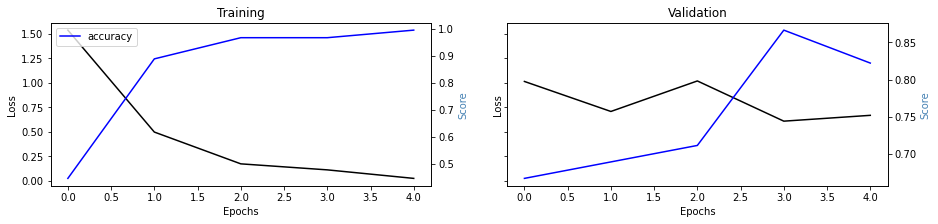

Iteração: 6 Fold: 8 Accuracy: 0.7857142857142857, Mean Accuracy: 0.8169642857142856
Epoch 1/5
23/23 [==============================] - 10s 206ms/step - loss: 1.7268 - accuracy: 0.3051 - val_loss: 1.1141 - val_accuracy: 0.5556
Epoch 2/5
23/23 [==============================] - 4s 168ms/step - loss: 0.8736 - accuracy: 0.7600 - val_loss: 0.4737 - val_accuracy: 0.9111
Epoch 3/5
23/23 [==============================] - 4s 177ms/step - loss: 0.2061 - accuracy: 0.9566 - val_loss: 0.6944 - val_accuracy: 0.7778
Epoch 4/5
23/23 [==============================] - 4s 160ms/step - loss: 0.0917 - accuracy: 0.9797 - val_loss: 0.4748 - val_accuracy: 0.8444
Epoch 5/5
23/23 [==============================] - 4s 184ms/step - loss: 0.0967 - accuracy: 0.9598 - val_loss: 0.8050 - val_accuracy: 0.7778


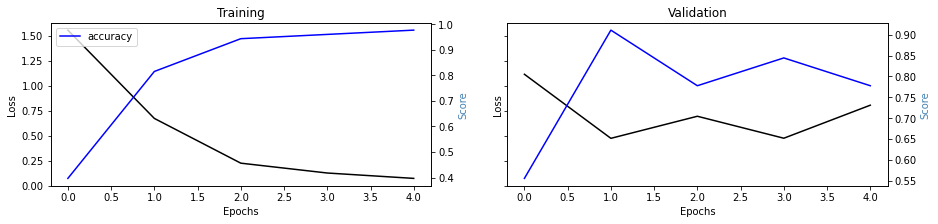

Iteração: 6 Fold: 9 Accuracy: 0.8392857142857143, Mean Accuracy: 0.8194444444444443
Epoch 1/5
23/23 [==============================] - 12s 306ms/step - loss: 1.7468 - accuracy: 0.3090 - val_loss: 1.0827 - val_accuracy: 0.6889
Epoch 2/5
23/23 [==============================] - 4s 165ms/step - loss: 0.6049 - accuracy: 0.8430 - val_loss: 1.0868 - val_accuracy: 0.6889
Epoch 3/5
23/23 [==============================] - 4s 175ms/step - loss: 0.1997 - accuracy: 0.9364 - val_loss: 0.6444 - val_accuracy: 0.8000
Epoch 4/5
23/23 [==============================] - 4s 172ms/step - loss: 0.1142 - accuracy: 0.9703 - val_loss: 0.7242 - val_accuracy: 0.8222
Epoch 5/5
23/23 [==============================] - 4s 167ms/step - loss: 0.1373 - accuracy: 0.9398 - val_loss: 0.7432 - val_accuracy: 0.8000


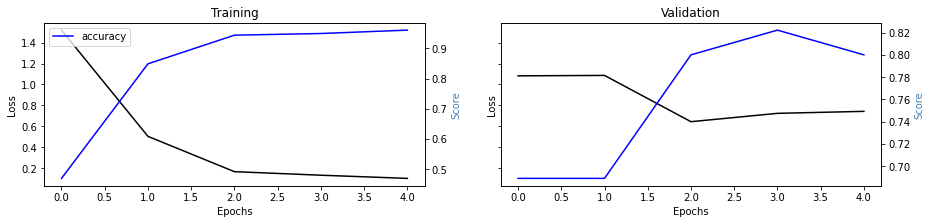

Iteração: 6 Fold: 10 Accuracy: 0.8214285714285714, Mean Accuracy: 0.8196428571428571
Epoch 1/5
23/23 [==============================] - 10s 220ms/step - loss: 1.7669 - accuracy: 0.3159 - val_loss: 1.3027 - val_accuracy: 0.5111
Epoch 2/5
23/23 [==============================] - 4s 167ms/step - loss: 0.7469 - accuracy: 0.7877 - val_loss: 0.7872 - val_accuracy: 0.8000
Epoch 3/5
23/23 [==============================] - 4s 183ms/step - loss: 0.2110 - accuracy: 0.9305 - val_loss: 0.7717 - val_accuracy: 0.7778
Epoch 4/5
23/23 [==============================] - 4s 180ms/step - loss: 0.1051 - accuracy: 0.9941 - val_loss: 0.5227 - val_accuracy: 0.8444
Epoch 5/5
23/23 [==============================] - 4s 182ms/step - loss: 0.0214 - accuracy: 1.0000 - val_loss: 0.7183 - val_accuracy: 0.8000


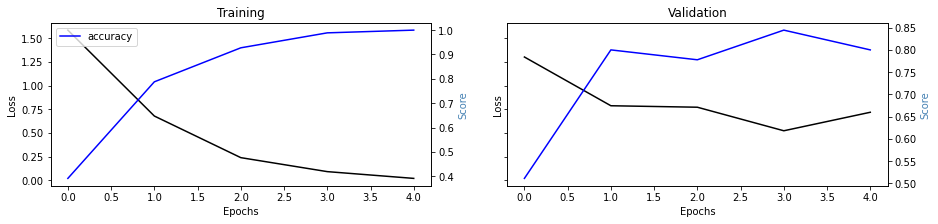

Iteração: 7 Fold: 1 Accuracy: 0.8392857142857143, Mean Accuracy: 0.8392857142857143
Epoch 1/5
23/23 [==============================] - 10s 226ms/step - loss: 1.7784 - accuracy: 0.3727 - val_loss: 1.1991 - val_accuracy: 0.4889
Epoch 2/5
23/23 [==============================] - 4s 170ms/step - loss: 0.6148 - accuracy: 0.8289 - val_loss: 0.6470 - val_accuracy: 0.7556
Epoch 3/5
23/23 [==============================] - 4s 184ms/step - loss: 0.1684 - accuracy: 0.9410 - val_loss: 0.5719 - val_accuracy: 0.8222
Epoch 4/5
23/23 [==============================] - 4s 168ms/step - loss: 0.1106 - accuracy: 0.9717 - val_loss: 0.5140 - val_accuracy: 0.8444
Epoch 5/5
23/23 [==============================] - 4s 167ms/step - loss: 0.0219 - accuracy: 1.0000 - val_loss: 0.5612 - val_accuracy: 0.8444


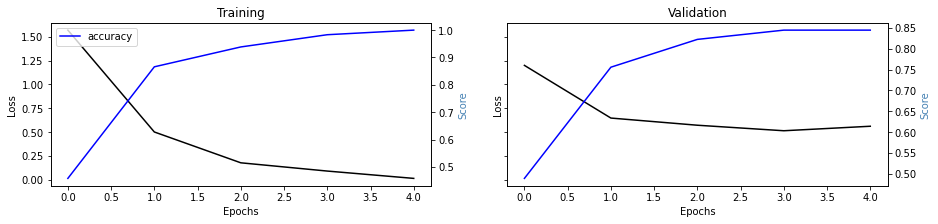

Iteração: 7 Fold: 2 Accuracy: 0.875, Mean Accuracy: 0.8571428571428572
Epoch 1/5
23/23 [==============================] - 11s 236ms/step - loss: 1.7895 - accuracy: 0.3204 - val_loss: 1.2397 - val_accuracy: 0.5333
Epoch 2/5
23/23 [==============================] - 4s 171ms/step - loss: 0.7552 - accuracy: 0.7685 - val_loss: 1.1941 - val_accuracy: 0.7111
Epoch 3/5
23/23 [==============================] - 4s 176ms/step - loss: 0.2124 - accuracy: 0.9452 - val_loss: 1.1682 - val_accuracy: 0.7333
Epoch 4/5
23/23 [==============================] - 4s 174ms/step - loss: 0.1320 - accuracy: 0.9370 - val_loss: 0.7943 - val_accuracy: 0.8000
Epoch 5/5
23/23 [==============================] - 4s 167ms/step - loss: 0.0711 - accuracy: 0.9796 - val_loss: 0.6630 - val_accuracy: 0.8000


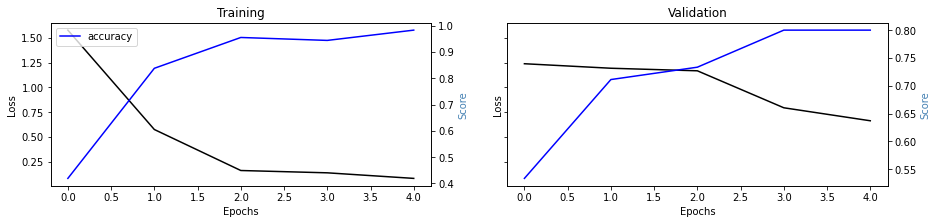

Iteração: 7 Fold: 3 Accuracy: 0.875, Mean Accuracy: 0.8630952380952381
Epoch 1/5
23/23 [==============================] - 10s 226ms/step - loss: 1.8575 - accuracy: 0.2360 - val_loss: 1.2074 - val_accuracy: 0.5556
Epoch 2/5
23/23 [==============================] - 4s 178ms/step - loss: 0.8338 - accuracy: 0.7934 - val_loss: 0.9079 - val_accuracy: 0.6889
Epoch 3/5
23/23 [==============================] - 4s 176ms/step - loss: 0.1935 - accuracy: 0.9519 - val_loss: 0.7461 - val_accuracy: 0.8444
Epoch 4/5
23/23 [==============================] - 4s 168ms/step - loss: 0.0553 - accuracy: 0.9982 - val_loss: 0.7201 - val_accuracy: 0.7778
Epoch 5/5
23/23 [==============================] - 4s 194ms/step - loss: 0.0096 - accuracy: 1.0000 - val_loss: 0.7422 - val_accuracy: 0.7778


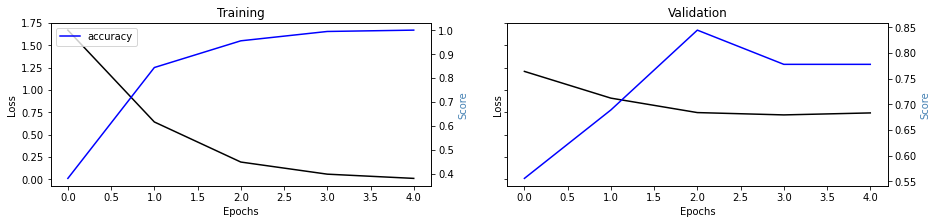

Iteração: 7 Fold: 4 Accuracy: 0.7857142857142857, Mean Accuracy: 0.84375
Epoch 1/5
23/23 [==============================] - 10s 212ms/step - loss: 1.8789 - accuracy: 0.2095 - val_loss: 1.1240 - val_accuracy: 0.6444
Epoch 2/5
23/23 [==============================] - 4s 167ms/step - loss: 0.6826 - accuracy: 0.8599 - val_loss: 0.7018 - val_accuracy: 0.8222
Epoch 3/5
23/23 [==============================] - 4s 172ms/step - loss: 0.2180 - accuracy: 0.9330 - val_loss: 0.8189 - val_accuracy: 0.8444
Epoch 4/5
23/23 [==============================] - 4s 181ms/step - loss: 0.1009 - accuracy: 0.9691 - val_loss: 0.7983 - val_accuracy: 0.8222
Epoch 5/5
23/23 [==============================] - 4s 169ms/step - loss: 0.1454 - accuracy: 0.9679 - val_loss: 0.7981 - val_accuracy: 0.7556


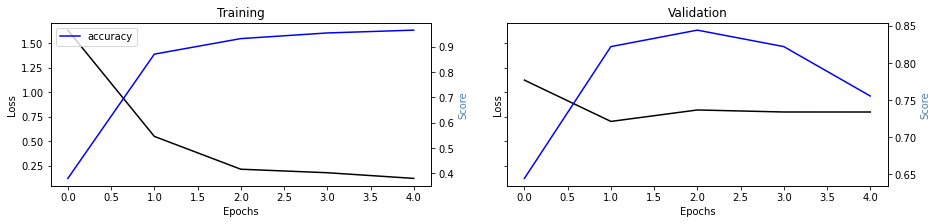

Iteração: 7 Fold: 5 Accuracy: 0.8035714285714286, Mean Accuracy: 0.8357142857142857
Epoch 1/5
23/23 [==============================] - 10s 215ms/step - loss: 1.7876 - accuracy: 0.3097 - val_loss: 1.1952 - val_accuracy: 0.6222
Epoch 2/5
23/23 [==============================] - 4s 170ms/step - loss: 0.8114 - accuracy: 0.7967 - val_loss: 0.6110 - val_accuracy: 0.8222
Epoch 3/5
23/23 [==============================] - 4s 167ms/step - loss: 0.2090 - accuracy: 0.9717 - val_loss: 0.9677 - val_accuracy: 0.7556
Epoch 4/5
23/23 [==============================] - 4s 172ms/step - loss: 0.1342 - accuracy: 0.9562 - val_loss: 0.8183 - val_accuracy: 0.7778
Epoch 5/5
23/23 [==============================] - 4s 168ms/step - loss: 0.0392 - accuracy: 0.9872 - val_loss: 0.7444 - val_accuracy: 0.7778


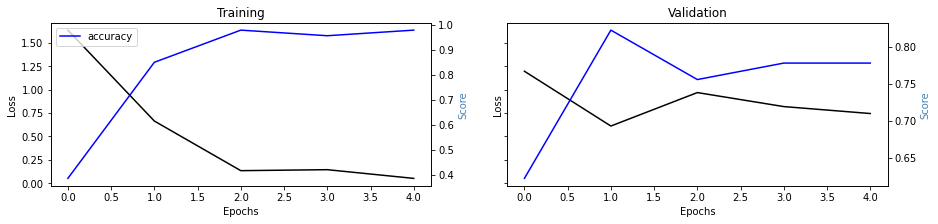

Iteração: 7 Fold: 6 Accuracy: 0.8392857142857143, Mean Accuracy: 0.8363095238095238
Epoch 1/5
23/23 [==============================] - 10s 208ms/step - loss: 1.9053 - accuracy: 0.2256 - val_loss: 1.1968 - val_accuracy: 0.5556
Epoch 2/5
23/23 [==============================] - 4s 167ms/step - loss: 0.7888 - accuracy: 0.7503 - val_loss: 0.5795 - val_accuracy: 0.8222
Epoch 3/5
23/23 [==============================] - 4s 173ms/step - loss: 0.2478 - accuracy: 0.9071 - val_loss: 0.5259 - val_accuracy: 0.8444
Epoch 4/5
23/23 [==============================] - 4s 162ms/step - loss: 0.0907 - accuracy: 0.9815 - val_loss: 0.3878 - val_accuracy: 0.8667
Epoch 5/5
23/23 [==============================] - 4s 169ms/step - loss: 0.0459 - accuracy: 0.9922 - val_loss: 0.3012 - val_accuracy: 0.9111


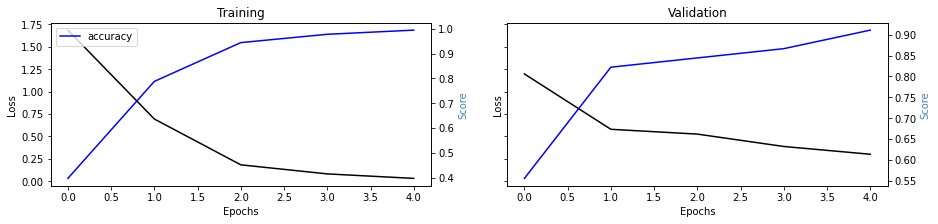

Iteração: 7 Fold: 7 Accuracy: 0.8571428571428571, Mean Accuracy: 0.8392857142857143
Epoch 1/5
23/23 [==============================] - 10s 215ms/step - loss: 1.7306 - accuracy: 0.3324 - val_loss: 0.9153 - val_accuracy: 0.7556
Epoch 2/5
23/23 [==============================] - 4s 168ms/step - loss: 0.5824 - accuracy: 0.7973 - val_loss: 0.9899 - val_accuracy: 0.6667
Epoch 3/5
23/23 [==============================] - 4s 171ms/step - loss: 0.2641 - accuracy: 0.9368 - val_loss: 0.7901 - val_accuracy: 0.6667
Epoch 4/5
23/23 [==============================] - 4s 172ms/step - loss: 0.0903 - accuracy: 0.9715 - val_loss: 0.6879 - val_accuracy: 0.7556
Epoch 5/5
23/23 [==============================] - 4s 160ms/step - loss: 0.0391 - accuracy: 0.9890 - val_loss: 0.5728 - val_accuracy: 0.8000


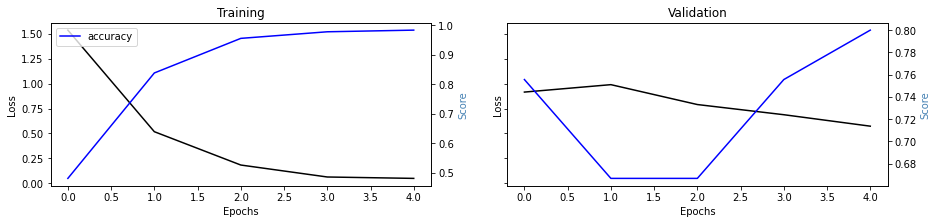

Iteração: 7 Fold: 8 Accuracy: 0.7678571428571429, Mean Accuracy: 0.8303571428571429
Epoch 1/5
23/23 [==============================] - 12s 206ms/step - loss: 1.8279 - accuracy: 0.2652 - val_loss: 0.9737 - val_accuracy: 0.7778
Epoch 2/5
23/23 [==============================] - 4s 167ms/step - loss: 0.7083 - accuracy: 0.8522 - val_loss: 0.7794 - val_accuracy: 0.7556
Epoch 3/5
23/23 [==============================] - 4s 182ms/step - loss: 0.1870 - accuracy: 0.9501 - val_loss: 1.1549 - val_accuracy: 0.6889
Epoch 4/5
23/23 [==============================] - 4s 173ms/step - loss: 0.1340 - accuracy: 0.9725 - val_loss: 0.5998 - val_accuracy: 0.8222
Epoch 5/5
23/23 [==============================] - 4s 167ms/step - loss: 0.0305 - accuracy: 0.9956 - val_loss: 0.8298 - val_accuracy: 0.7778


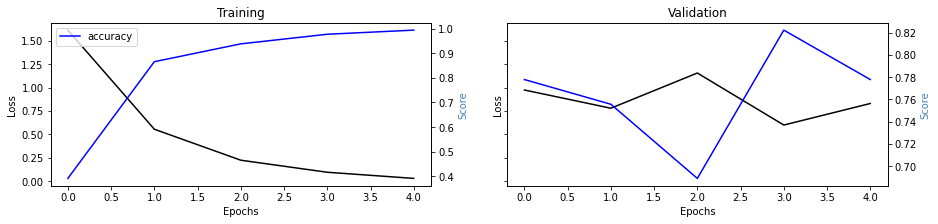

Iteração: 7 Fold: 9 Accuracy: 0.8392857142857143, Mean Accuracy: 0.8313492063492064
Epoch 1/5
23/23 [==============================] - 10s 223ms/step - loss: 1.7952 - accuracy: 0.3569 - val_loss: 1.2146 - val_accuracy: 0.5778
Epoch 2/5
23/23 [==============================] - 4s 170ms/step - loss: 0.6652 - accuracy: 0.7955 - val_loss: 0.5992 - val_accuracy: 0.8000
Epoch 3/5
23/23 [==============================] - 4s 189ms/step - loss: 0.1463 - accuracy: 0.9604 - val_loss: 0.7713 - val_accuracy: 0.7333
Epoch 4/5
23/23 [==============================] - 4s 189ms/step - loss: 0.1336 - accuracy: 0.9592 - val_loss: 0.5995 - val_accuracy: 0.8444
Epoch 5/5
23/23 [==============================] - 4s 171ms/step - loss: 0.0405 - accuracy: 0.9855 - val_loss: 0.5769 - val_accuracy: 0.8889


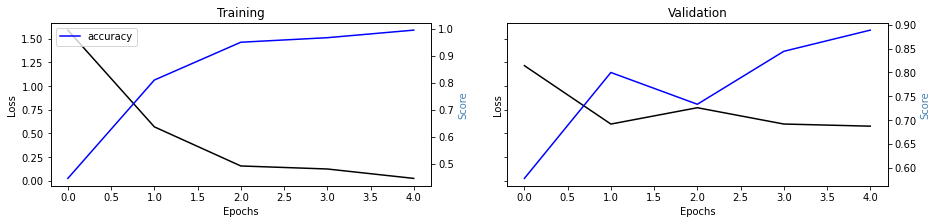

Iteração: 7 Fold: 10 Accuracy: 0.875, Mean Accuracy: 0.8357142857142857
Epoch 1/5
23/23 [==============================] - 10s 218ms/step - loss: 1.8616 - accuracy: 0.2754 - val_loss: 1.4164 - val_accuracy: 0.4444
Epoch 2/5
23/23 [==============================] - 4s 164ms/step - loss: 0.8719 - accuracy: 0.7026 - val_loss: 0.8351 - val_accuracy: 0.6889
Epoch 3/5
23/23 [==============================] - 4s 193ms/step - loss: 0.2303 - accuracy: 0.9258 - val_loss: 0.7895 - val_accuracy: 0.8000
Epoch 4/5
23/23 [==============================] - 4s 180ms/step - loss: 0.1067 - accuracy: 0.9751 - val_loss: 0.5873 - val_accuracy: 0.8444
Epoch 5/5
23/23 [==============================] - 4s 166ms/step - loss: 0.0253 - accuracy: 0.9950 - val_loss: 0.7510 - val_accuracy: 0.7778


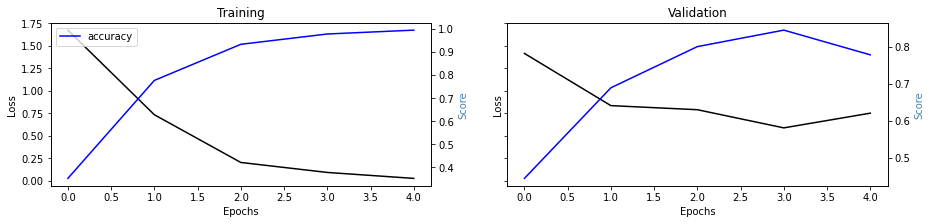

Iteração: 8 Fold: 1 Accuracy: 0.8214285714285714, Mean Accuracy: 0.8214285714285714
Epoch 1/5
23/23 [==============================] - 10s 208ms/step - loss: 1.8192 - accuracy: 0.2589 - val_loss: 0.9717 - val_accuracy: 0.7778
Epoch 2/5
23/23 [==============================] - 4s 169ms/step - loss: 0.5982 - accuracy: 0.8822 - val_loss: 0.8318 - val_accuracy: 0.7111
Epoch 3/5
23/23 [==============================] - 4s 167ms/step - loss: 0.2252 - accuracy: 0.9310 - val_loss: 0.6300 - val_accuracy: 0.7556
Epoch 4/5
23/23 [==============================] - 4s 170ms/step - loss: 0.0721 - accuracy: 0.9779 - val_loss: 0.4199 - val_accuracy: 0.8667
Epoch 5/5
23/23 [==============================] - 4s 161ms/step - loss: 0.0583 - accuracy: 0.9853 - val_loss: 0.4989 - val_accuracy: 0.8222


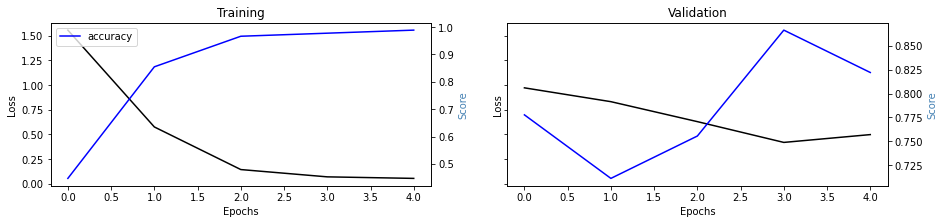

Iteração: 8 Fold: 2 Accuracy: 0.8214285714285714, Mean Accuracy: 0.8214285714285714
Epoch 1/5
23/23 [==============================] - 12s 222ms/step - loss: 1.7327 - accuracy: 0.2612 - val_loss: 1.1903 - val_accuracy: 0.6444
Epoch 2/5
23/23 [==============================] - 4s 176ms/step - loss: 0.6961 - accuracy: 0.8399 - val_loss: 0.9112 - val_accuracy: 0.7333
Epoch 3/5
23/23 [==============================] - 4s 187ms/step - loss: 0.1852 - accuracy: 0.9677 - val_loss: 1.2353 - val_accuracy: 0.7556
Epoch 4/5
23/23 [==============================] - 4s 192ms/step - loss: 0.1556 - accuracy: 0.9314 - val_loss: 0.9543 - val_accuracy: 0.7778
Epoch 5/5
23/23 [==============================] - 4s 177ms/step - loss: 0.0362 - accuracy: 0.9868 - val_loss: 0.8652 - val_accuracy: 0.7556


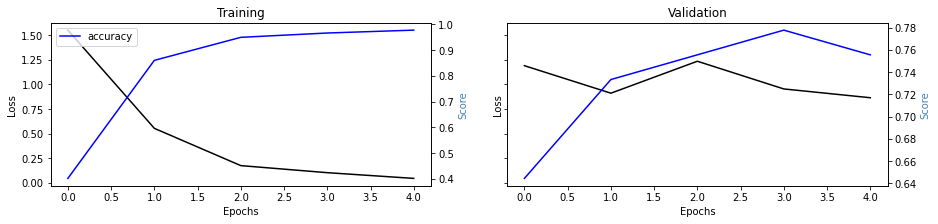

Iteração: 8 Fold: 3 Accuracy: 0.8214285714285714, Mean Accuracy: 0.8214285714285715
Epoch 1/5
23/23 [==============================] - 10s 212ms/step - loss: 1.7818 - accuracy: 0.3002 - val_loss: 1.2048 - val_accuracy: 0.5556
Epoch 2/5
23/23 [==============================] - 4s 185ms/step - loss: 0.6606 - accuracy: 0.8031 - val_loss: 1.0251 - val_accuracy: 0.6667
Epoch 3/5
23/23 [==============================] - 4s 178ms/step - loss: 0.3085 - accuracy: 0.8779 - val_loss: 1.0880 - val_accuracy: 0.7778
Epoch 4/5
23/23 [==============================] - 4s 170ms/step - loss: 0.0609 - accuracy: 0.9941 - val_loss: 1.1857 - val_accuracy: 0.7333
Epoch 5/5
23/23 [==============================] - 4s 170ms/step - loss: 0.0414 - accuracy: 0.9923 - val_loss: 1.4400 - val_accuracy: 0.7333


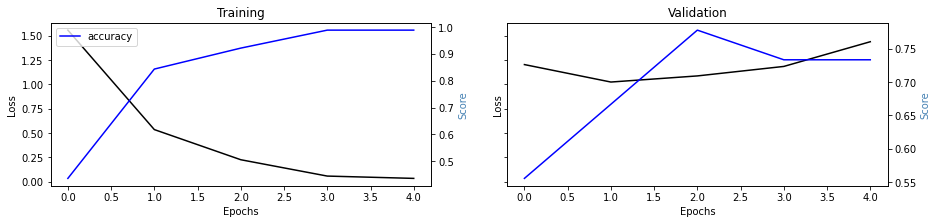

Iteração: 8 Fold: 4 Accuracy: 0.7321428571428571, Mean Accuracy: 0.7991071428571429
Epoch 1/5
23/23 [==============================] - 10s 205ms/step - loss: 1.7960 - accuracy: 0.2875 - val_loss: 1.1196 - val_accuracy: 0.6444
Epoch 2/5
23/23 [==============================] - 4s 177ms/step - loss: 0.6175 - accuracy: 0.9293 - val_loss: 0.5273 - val_accuracy: 0.8667
Epoch 3/5
23/23 [==============================] - 4s 163ms/step - loss: 0.1667 - accuracy: 0.9468 - val_loss: 0.7277 - val_accuracy: 0.8222
Epoch 4/5
23/23 [==============================] - 4s 168ms/step - loss: 0.1408 - accuracy: 0.9556 - val_loss: 0.5929 - val_accuracy: 0.8222
Epoch 5/5
23/23 [==============================] - 4s 168ms/step - loss: 0.0583 - accuracy: 1.0000 - val_loss: 0.6167 - val_accuracy: 0.8444


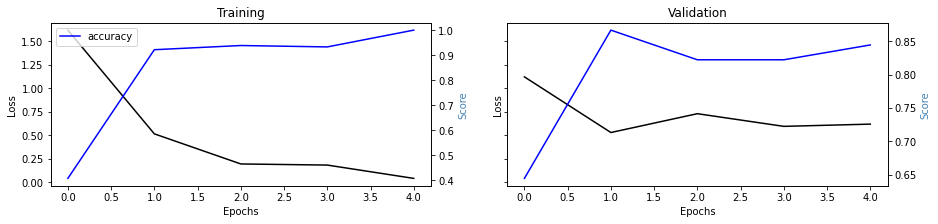

Iteração: 8 Fold: 5 Accuracy: 0.8035714285714286, Mean Accuracy: 0.8
Epoch 1/5
23/23 [==============================] - 10s 219ms/step - loss: 1.7709 - accuracy: 0.3610 - val_loss: 1.0270 - val_accuracy: 0.7333
Epoch 2/5
23/23 [==============================] - 4s 183ms/step - loss: 0.6837 - accuracy: 0.8915 - val_loss: 0.6970 - val_accuracy: 0.8000
Epoch 3/5
23/23 [==============================] - 4s 171ms/step - loss: 0.1815 - accuracy: 0.9465 - val_loss: 0.6045 - val_accuracy: 0.8000
Epoch 4/5
23/23 [==============================] - 4s 170ms/step - loss: 0.0984 - accuracy: 0.9846 - val_loss: 0.4763 - val_accuracy: 0.8000
Epoch 5/5
23/23 [==============================] - 4s 169ms/step - loss: 0.0463 - accuracy: 0.9792 - val_loss: 0.4578 - val_accuracy: 0.8222


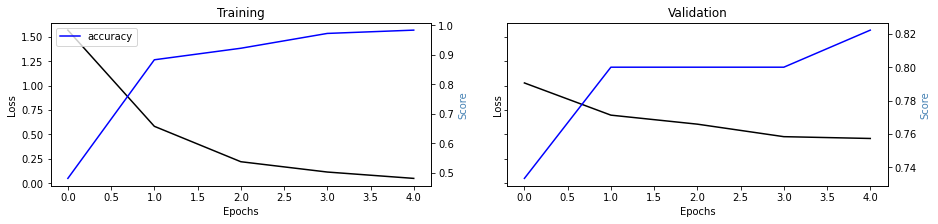

Iteração: 8 Fold: 6 Accuracy: 0.875, Mean Accuracy: 0.8125
Epoch 1/5
23/23 [==============================] - 12s 286ms/step - loss: 1.6773 - accuracy: 0.3779 - val_loss: 1.2159 - val_accuracy: 0.4667
Epoch 2/5
23/23 [==============================] - 4s 172ms/step - loss: 0.7199 - accuracy: 0.8233 - val_loss: 0.5499 - val_accuracy: 0.7556
Epoch 3/5
23/23 [==============================] - 4s 175ms/step - loss: 0.2104 - accuracy: 0.9385 - val_loss: 0.3442 - val_accuracy: 0.9333
Epoch 4/5
23/23 [==============================] - 4s 184ms/step - loss: 0.0610 - accuracy: 0.9822 - val_loss: 0.5937 - val_accuracy: 0.8889
Epoch 5/5
23/23 [==============================] - 5s 200ms/step - loss: 0.1456 - accuracy: 0.9638 - val_loss: 0.3604 - val_accuracy: 0.8889


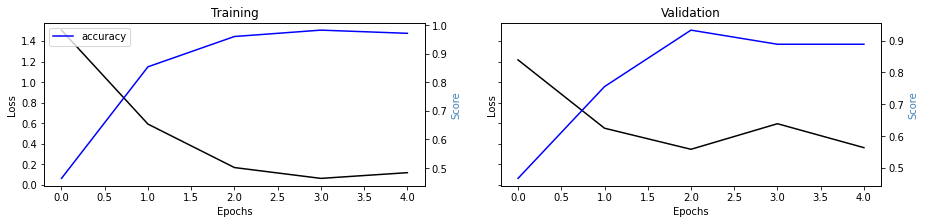

Iteração: 8 Fold: 7 Accuracy: 0.8928571428571429, Mean Accuracy: 0.8239795918367347
Epoch 1/5
23/23 [==============================] - 10s 222ms/step - loss: 1.8331 - accuracy: 0.2868 - val_loss: 1.2014 - val_accuracy: 0.5778
Epoch 2/5
23/23 [==============================] - 4s 179ms/step - loss: 0.7722 - accuracy: 0.7977 - val_loss: 1.0086 - val_accuracy: 0.6889
Epoch 3/5
23/23 [==============================] - 4s 186ms/step - loss: 0.2792 - accuracy: 0.9236 - val_loss: 0.6701 - val_accuracy: 0.8000
Epoch 4/5
23/23 [==============================] - 4s 166ms/step - loss: 0.0708 - accuracy: 0.9902 - val_loss: 0.6818 - val_accuracy: 0.8444
Epoch 5/5
23/23 [==============================] - 4s 181ms/step - loss: 0.0407 - accuracy: 0.9875 - val_loss: 0.6669 - val_accuracy: 0.8222


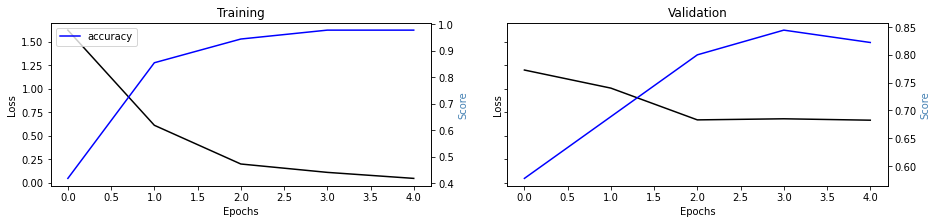

Iteração: 8 Fold: 8 Accuracy: 0.75, Mean Accuracy: 0.8147321428571429
Epoch 1/5
23/23 [==============================] - 10s 213ms/step - loss: 1.8713 - accuracy: 0.2213 - val_loss: 1.0934 - val_accuracy: 0.5778
Epoch 2/5
23/23 [==============================] - 4s 170ms/step - loss: 0.7120 - accuracy: 0.8117 - val_loss: 0.6327 - val_accuracy: 0.7778
Epoch 3/5
23/23 [==============================] - 4s 173ms/step - loss: 0.1572 - accuracy: 0.9645 - val_loss: 0.6579 - val_accuracy: 0.7778
Epoch 4/5
23/23 [==============================] - 4s 165ms/step - loss: 0.0749 - accuracy: 0.9913 - val_loss: 0.6397 - val_accuracy: 0.7778
Epoch 5/5
23/23 [==============================] - 4s 174ms/step - loss: 0.1001 - accuracy: 0.9768 - val_loss: 0.7050 - val_accuracy: 0.7778


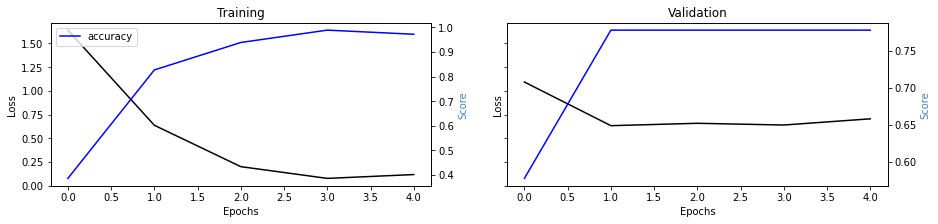

Iteração: 8 Fold: 9 Accuracy: 0.8392857142857143, Mean Accuracy: 0.8174603174603176
Epoch 1/5
23/23 [==============================] - 10s 227ms/step - loss: 1.7495 - accuracy: 0.3588 - val_loss: 1.0336 - val_accuracy: 0.6667
Epoch 2/5
23/23 [==============================] - 4s 180ms/step - loss: 0.5562 - accuracy: 0.8496 - val_loss: 0.7950 - val_accuracy: 0.7556
Epoch 3/5
23/23 [==============================] - 4s 174ms/step - loss: 0.1730 - accuracy: 0.9846 - val_loss: 0.7079 - val_accuracy: 0.7778
Epoch 4/5
23/23 [==============================] - 4s 168ms/step - loss: 0.1016 - accuracy: 0.9762 - val_loss: 0.9083 - val_accuracy: 0.8222
Epoch 5/5
23/23 [==============================] - 4s 180ms/step - loss: 0.0329 - accuracy: 0.9881 - val_loss: 0.7509 - val_accuracy: 0.8444


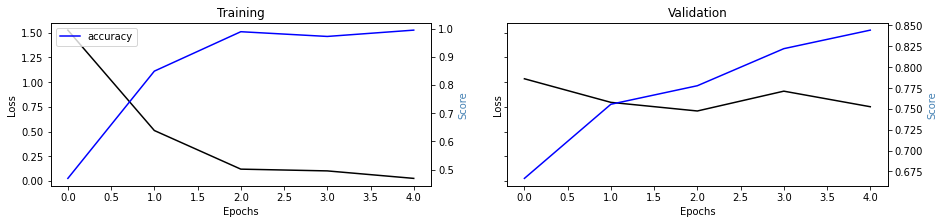

Iteração: 8 Fold: 10 Accuracy: 0.8571428571428571, Mean Accuracy: 0.8214285714285715
Epoch 1/5
23/23 [==============================] - 10s 210ms/step - loss: 1.8179 - accuracy: 0.2925 - val_loss: 1.1524 - val_accuracy: 0.7333
Epoch 2/5
23/23 [==============================] - 4s 173ms/step - loss: 0.7401 - accuracy: 0.8471 - val_loss: 0.7342 - val_accuracy: 0.7556
Epoch 3/5
23/23 [==============================] - 4s 169ms/step - loss: 0.1766 - accuracy: 0.9330 - val_loss: 0.6451 - val_accuracy: 0.8444
Epoch 4/5
23/23 [==============================] - 4s 177ms/step - loss: 0.0854 - accuracy: 0.9680 - val_loss: 0.9482 - val_accuracy: 0.8222
Epoch 5/5
23/23 [==============================] - 4s 175ms/step - loss: 0.0967 - accuracy: 0.9753 - val_loss: 0.7650 - val_accuracy: 0.8000


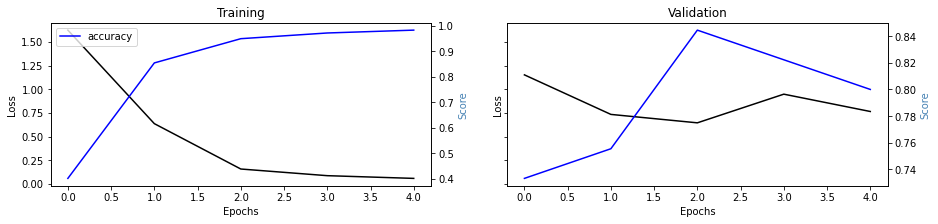

Iteração: 9 Fold: 1 Accuracy: 0.8214285714285714, Mean Accuracy: 0.8214285714285714
Epoch 1/5
23/23 [==============================] - 10s 215ms/step - loss: 1.8424 - accuracy: 0.2911 - val_loss: 1.3454 - val_accuracy: 0.4444
Epoch 2/5
23/23 [==============================] - 4s 171ms/step - loss: 0.7610 - accuracy: 0.7997 - val_loss: 0.6463 - val_accuracy: 0.8000
Epoch 3/5
23/23 [==============================] - 4s 177ms/step - loss: 0.2547 - accuracy: 0.9591 - val_loss: 0.4751 - val_accuracy: 0.8667
Epoch 4/5
23/23 [==============================] - 4s 166ms/step - loss: 0.0873 - accuracy: 0.9773 - val_loss: 0.6150 - val_accuracy: 0.8000
Epoch 5/5
23/23 [==============================] - 4s 166ms/step - loss: 0.0542 - accuracy: 0.9779 - val_loss: 0.5583 - val_accuracy: 0.8000


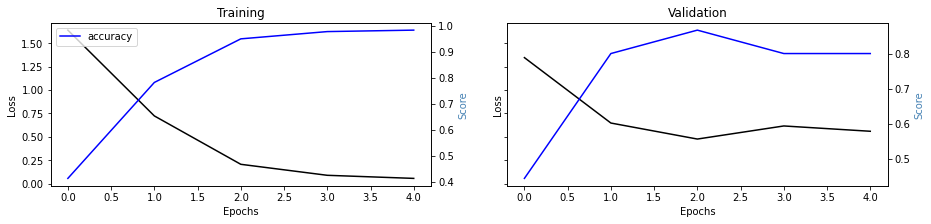

Iteração: 9 Fold: 2 Accuracy: 0.7857142857142857, Mean Accuracy: 0.8035714285714286
Epoch 1/5
23/23 [==============================] - 10s 212ms/step - loss: 1.7876 - accuracy: 0.3298 - val_loss: 1.2786 - val_accuracy: 0.5778
Epoch 2/5
23/23 [==============================] - 4s 163ms/step - loss: 0.8281 - accuracy: 0.7823 - val_loss: 0.8700 - val_accuracy: 0.8000
Epoch 3/5
23/23 [==============================] - 4s 184ms/step - loss: 0.3167 - accuracy: 0.9038 - val_loss: 0.9710 - val_accuracy: 0.8000
Epoch 4/5
23/23 [==============================] - 4s 183ms/step - loss: 0.0653 - accuracy: 0.9908 - val_loss: 0.8943 - val_accuracy: 0.7556
Epoch 5/5
23/23 [==============================] - 4s 171ms/step - loss: 0.0183 - accuracy: 1.0000 - val_loss: 0.9468 - val_accuracy: 0.7778


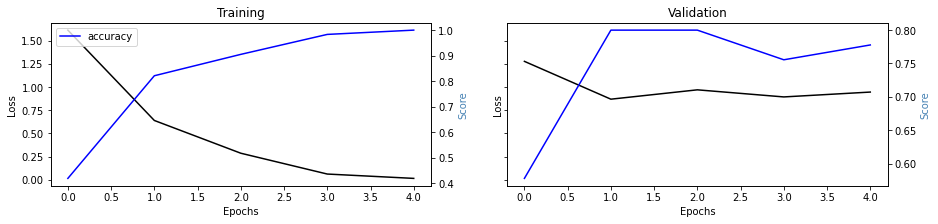

Iteração: 9 Fold: 3 Accuracy: 0.8571428571428571, Mean Accuracy: 0.8214285714285715
Epoch 1/5
23/23 [==============================] - 10s 213ms/step - loss: 1.6854 - accuracy: 0.3516 - val_loss: 1.0931 - val_accuracy: 0.7111
Epoch 2/5
23/23 [==============================] - 4s 179ms/step - loss: 0.5984 - accuracy: 0.8731 - val_loss: 0.8122 - val_accuracy: 0.7556
Epoch 3/5
23/23 [==============================] - 4s 171ms/step - loss: 0.2427 - accuracy: 0.9185 - val_loss: 1.0332 - val_accuracy: 0.7556
Epoch 4/5
23/23 [==============================] - 4s 184ms/step - loss: 0.0737 - accuracy: 0.9832 - val_loss: 1.1477 - val_accuracy: 0.7556
Epoch 5/5
23/23 [==============================] - 4s 167ms/step - loss: 0.0460 - accuracy: 0.9876 - val_loss: 0.8923 - val_accuracy: 0.8000


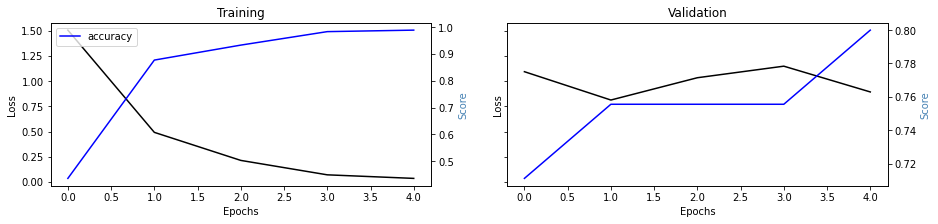

Iteração: 9 Fold: 4 Accuracy: 0.8392857142857143, Mean Accuracy: 0.8258928571428572
Epoch 1/5
23/23 [==============================] - 10s 210ms/step - loss: 1.8369 - accuracy: 0.2675 - val_loss: 1.1481 - val_accuracy: 0.6000
Epoch 2/5
23/23 [==============================] - 4s 194ms/step - loss: 0.6771 - accuracy: 0.7961 - val_loss: 0.7873 - val_accuracy: 0.7778
Epoch 3/5
23/23 [==============================] - 4s 165ms/step - loss: 0.2306 - accuracy: 0.9460 - val_loss: 0.7562 - val_accuracy: 0.8000
Epoch 4/5
23/23 [==============================] - 4s 183ms/step - loss: 0.0736 - accuracy: 0.9801 - val_loss: 0.6609 - val_accuracy: 0.8889
Epoch 5/5
23/23 [==============================] - 4s 174ms/step - loss: 0.0419 - accuracy: 0.9854 - val_loss: 0.7659 - val_accuracy: 0.8667


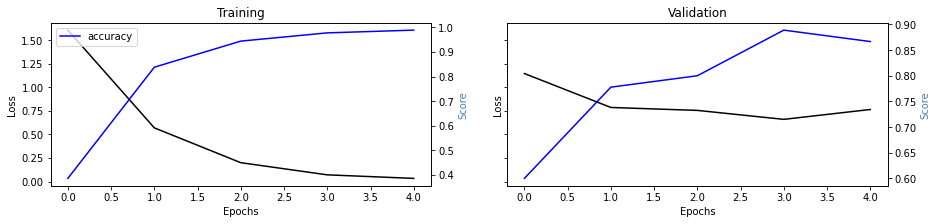

Iteração: 9 Fold: 5 Accuracy: 0.875, Mean Accuracy: 0.8357142857142857
Epoch 1/5
23/23 [==============================] - 12s 223ms/step - loss: 1.8864 - accuracy: 0.2310 - val_loss: 1.1744 - val_accuracy: 0.6222
Epoch 2/5
23/23 [==============================] - 4s 173ms/step - loss: 0.7924 - accuracy: 0.8087 - val_loss: 0.6677 - val_accuracy: 0.7556
Epoch 3/5
23/23 [==============================] - 4s 165ms/step - loss: 0.2228 - accuracy: 0.9668 - val_loss: 0.5721 - val_accuracy: 0.7778
Epoch 4/5
23/23 [==============================] - 4s 181ms/step - loss: 0.0969 - accuracy: 0.9701 - val_loss: 0.7381 - val_accuracy: 0.8444
Epoch 5/5
23/23 [==============================] - 4s 178ms/step - loss: 0.0823 - accuracy: 0.9834 - val_loss: 0.7667 - val_accuracy: 0.7778


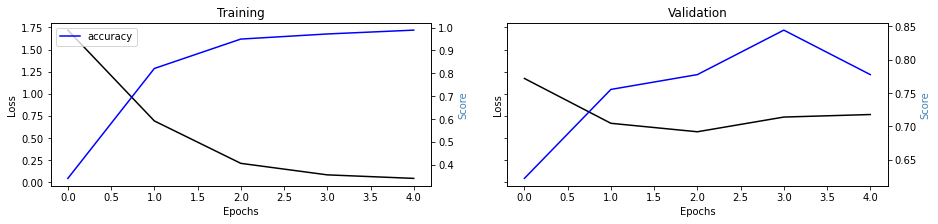

Iteração: 9 Fold: 6 Accuracy: 0.8392857142857143, Mean Accuracy: 0.8363095238095238
Epoch 1/5
23/23 [==============================] - 10s 228ms/step - loss: 1.7926 - accuracy: 0.2901 - val_loss: 1.1406 - val_accuracy: 0.6667
Epoch 2/5
23/23 [==============================] - 4s 185ms/step - loss: 0.7076 - accuracy: 0.7970 - val_loss: 0.4644 - val_accuracy: 0.8889
Epoch 3/5
23/23 [==============================] - 4s 172ms/step - loss: 0.1832 - accuracy: 0.9515 - val_loss: 0.3537 - val_accuracy: 0.8000
Epoch 4/5
23/23 [==============================] - 4s 175ms/step - loss: 0.1136 - accuracy: 0.9574 - val_loss: 0.5778 - val_accuracy: 0.8222
Epoch 5/5
23/23 [==============================] - 4s 178ms/step - loss: 0.0913 - accuracy: 0.9684 - val_loss: 0.4874 - val_accuracy: 0.8444


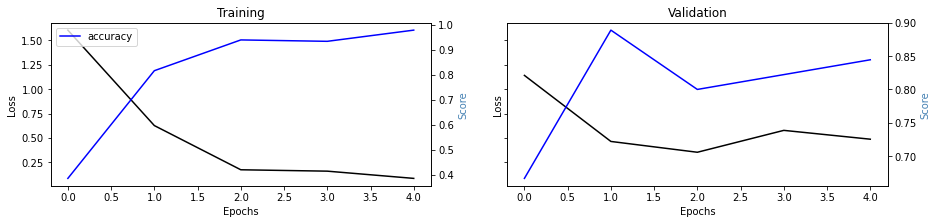

Iteração: 9 Fold: 7 Accuracy: 0.7857142857142857, Mean Accuracy: 0.8290816326530612
Epoch 1/5
23/23 [==============================] - 10s 215ms/step - loss: 1.8237 - accuracy: 0.2777 - val_loss: 1.1464 - val_accuracy: 0.5556
Epoch 2/5
23/23 [==============================] - 4s 182ms/step - loss: 0.7004 - accuracy: 0.8326 - val_loss: 0.9904 - val_accuracy: 0.5778
Epoch 3/5
23/23 [==============================] - 4s 181ms/step - loss: 0.1752 - accuracy: 0.9465 - val_loss: 0.6236 - val_accuracy: 0.8000
Epoch 4/5
23/23 [==============================] - 4s 173ms/step - loss: 0.1245 - accuracy: 0.9490 - val_loss: 0.5840 - val_accuracy: 0.7778
Epoch 5/5
23/23 [==============================] - 4s 176ms/step - loss: 0.0186 - accuracy: 1.0000 - val_loss: 0.6173 - val_accuracy: 0.8444


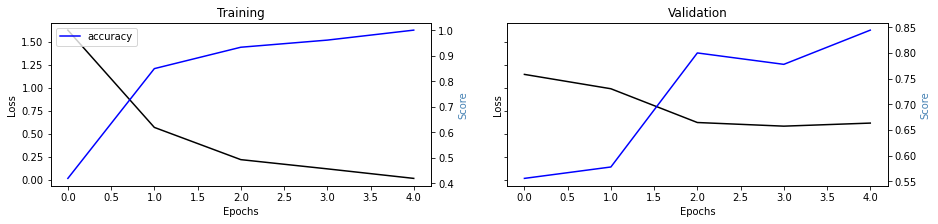

Iteração: 9 Fold: 8 Accuracy: 0.7678571428571429, Mean Accuracy: 0.8214285714285715
Epoch 1/5
23/23 [==============================] - 10s 213ms/step - loss: 1.8245 - accuracy: 0.2849 - val_loss: 1.1556 - val_accuracy: 0.5333
Epoch 2/5
23/23 [==============================] - 4s 173ms/step - loss: 0.8127 - accuracy: 0.7611 - val_loss: 0.6487 - val_accuracy: 0.7333
Epoch 3/5
20/23 [=========================>....] - ETA: 0s - loss: 0.2293 - accuracy: 0.9305

In [ ]:
final_mean = []
conf_matrix_list_of_arrays = []
for i in range(10):

    accrs = []
    fold=0
#     conf_matrix_list_of_arrays = []

    k=10
    sss = StratifiedShuffleSplit(n_splits=k, test_size=0.2, random_state=42)

    for train_index, test_index in sss.split(X, y):

        fold +=1

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model, predicted_prob, predicted = fit_bert_classif(X_train, y_train, X_test, encode_y=True, 
                                                            model=None, epochs=5, batch_size=8)
        # Validade Test Set
        accr = metrics.accuracy_score(y_test, predicted)
        #
        conf_matrix = confusion_matrix(y_test, predicted)
        conf_matrix_list_of_arrays.append(conf_matrix)
        #
        accrs.append(accr)

        print(f'Iteração: {i+1} Fold: {fold} Accuracy: {accr}, Mean Accuracy: {sum(accrs)/fold}')
    final_mean.append(sum(accrs)/k)

# means for Confusion Matrix
mean_of_conf_matrix_arrays = np.mean(conf_matrix_list_of_arrays, axis=0)

In [40]:
print(f'Iterações: {len(final_mean)} | CV: {fold} | Média Final: {sum(final_mean)/len(final_mean)}')

Iterações: 1 | CV: 10 | Média Final: 0.8375


In [41]:
final_mean

[0.8375]

### Evaluate

#### Plot Metrics Resume and Confusion Matrix

                                          Metrics Resume                                          
Class Name          	 Precision	    Recall	  F1-Score	       MCC	       AUC
Design Document     	       1.0	      0.88	      0.93	      0.93	      0.94
List of Contributors	       1.0	       1.0	       1.0	       1.0	       1.0
Setup Files         	      0.75	      0.86	       0.8	      0.77	      0.91
Requirement Document	       1.0	      0.88	      0.93	      0.93	      0.94
License             	       1.0	       1.0	       1.0	       1.0	       1.0
Contributors' Guide 	      0.75	      0.75	      0.75	      0.71	      0.85
Release Notes       	      0.75	      0.86	       0.8	      0.77	      0.91

Macro Average       	      0.89	      0.89	      0.89	      0.87	      0.93
Micro Average       	      0.89	      0.89	      0.89	      0.77	      0.93


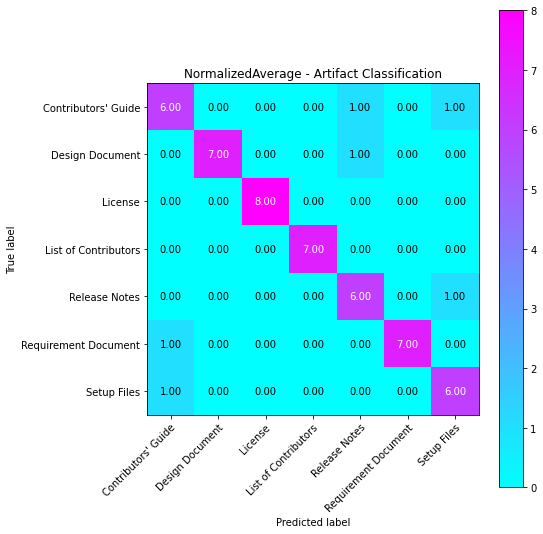

In [42]:
uf.custom_metrics(mean_of_conf_matrix_arrays, np.unique(y_test))

## GloVe with Conventional ML

### Create the Feature Vector

In [105]:
class Word2VecVectorizer:
  def __init__(self, word_vect):
    print("Loading in word vectors...")
    self.word_vectors = word_vect
    print("Finished loading in word vectors")

  def fit(self, data):
    pass

  def transform(self, data):
    # determine the dimensionality of vectors
    v = self.word_vectors.get_vector('king')
    self.D = v.shape[0]

    X = np.zeros((len(data), self.D))
    n = 0
    emptycount = 0
    for sentence in data:
      tokens = sentence.split()
      vecs = []
      m = 0
      for word in tokens:
        try:
          # throws KeyError if word not found
          vec = self.word_vectors.get_vector(word)
          vecs.append(vec)
          m += 1
        except KeyError:
          pass
      if len(vecs) > 0:
        vecs = np.array(vecs)
        X[n] = vecs.mean(axis=0)
      else:
        emptycount += 1
      n += 1
    print("Number of samples with no words found: %s / %s" % (emptycount, len(data)))
    return X


  def fit_transform(self, data):
    self.fit(data)
    return self.transform(data)

### Vetorization

In [106]:
# Set a word vectorizer
vectorizer = Word2VecVectorizer(word_vect)
# Get the sentence embeddings for the train and test datasets
X = corpus

y = df["Label"].values

# Use for mNB
from sklearn.preprocessing import MinMaxScaler, normalize
def normalizer(X):
    scaler = MinMaxScaler()
    scaled_X = scaler.fit_transform(X)
    normalized_X = normalize(scaled_X, norm='max', axis=0, copy=True)
    return(normalized_X)

Loading in word vectors...
Finished loading in word vectors


### Cross Validation and Fitting the Model

In [107]:
def encode_y_train(y_train):
    vectorizer = LabelEncoder()
    y_train = vectorizer.fit_transform(y_train)
    return y_train

In [ ]:
dic_y_mapping = {n:label for n,label in enumerate(np.unique(y))}

In [112]:
final_mean = []
conf_matrix_list_of_arrays = []
for i in range(10):

    accrs = []
    preds = []
    # conf_matrix_list_of_arrays = []
    k = 10
    fold = 0
    
    sss = StratifiedShuffleSplit(n_splits=k, test_size=0.2, random_state=42)

    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        fold +=1

        X_train = vectorizer.fit_transform(X_train)
        X_train = normalizer(X_train) # Use for mNB
        X_test = vectorizer.transform(X_test)
        X_test = normalizer(X_test) # Use for mNB

        y_train=encode_y_train(y_train)

        # train classifier
        model = nb.fit(X_train, y_train)


        # test
        predicted_prob = model.predict_proba(X_test)
        predicted = [dic_y_mapping[np.argmax(pred)] for pred in 
                 predicted_prob]
    #
        conf_matrix = confusion_matrix(y_test, predicted)
        conf_matrix_list_of_arrays .append(conf_matrix)
    #    
        accr = metrics.accuracy_score(y_test, predicted)
        accrs.append(accr)
        preds.append(predicted)    

        print('\n--------------------------------------------------------------------')
        print(f'Iteração: {i+1} Fold: {fold} Accuracy: {accr}, Mean Accuracy: {sum(accrs)/fold}')
        print('--------------------------------------------------------------------')
    final_mean.append(sum(accrs)/k)

mean_of_conf_matrix_arrays = np.mean(conf_matrix_list_of_arrays, axis=0)

mean_of_conf_matrix_arrays = np.mean(conf_matrix_list_of_arrays, axis=0)

Number of samples with no words found: 0 / 224
Number of samples with no words found: 0 / 56

--------------------------------------------------------------------
Iteração: 1 Fold: 1 Accuracy: 0.7857142857142857, Mean Accuracy: 0.7857142857142857
--------------------------------------------------------------------
Number of samples with no words found: 0 / 224
Number of samples with no words found: 0 / 56

--------------------------------------------------------------------
Iteração: 1 Fold: 2 Accuracy: 0.6428571428571429, Mean Accuracy: 0.7142857142857143
--------------------------------------------------------------------
Number of samples with no words found: 0 / 224
Number of samples with no words found: 0 / 56

--------------------------------------------------------------------
Iteração: 1 Fold: 3 Accuracy: 0.6428571428571429, Mean Accuracy: 0.6904761904761906
--------------------------------------------------------------------
Number of samples with no words found: 0 / 224
Numbe

In [115]:
print(f'Iterações: {len(final_mean)} | CV: {fold} | Média Final: {sum(final_mean)/len(final_mean)}')

Iterações: 10 | CV: 10 | Média Final: 0.6625


### Evaluate

                                          Metrics Resume                                          
Class Name          	 Precision	    Recall	  F1-Score	       MCC	       AUC
Contributors' Guide 	      0.71	      0.71	      0.71	      0.67	      0.83
Design Document     	      0.42	      0.71	      0.53	      0.45	      0.78
License             	       1.0	       1.0	       1.0	       1.0	       1.0
List of Contributors	       1.0	      0.86	      0.92	      0.92	      0.93
Release Notes       	      0.67	      0.57	      0.62	      0.56	      0.76
Requirement Document	      0.67	      0.25	      0.36	      0.35	      0.61
Setup Files         	      0.75	       1.0	      0.86	      0.85	      0.98

Macro Average       	      0.74	      0.73	      0.71	      0.68	      0.84
Micro Average       	      0.72	      0.72	      0.72	      0.85	      0.84


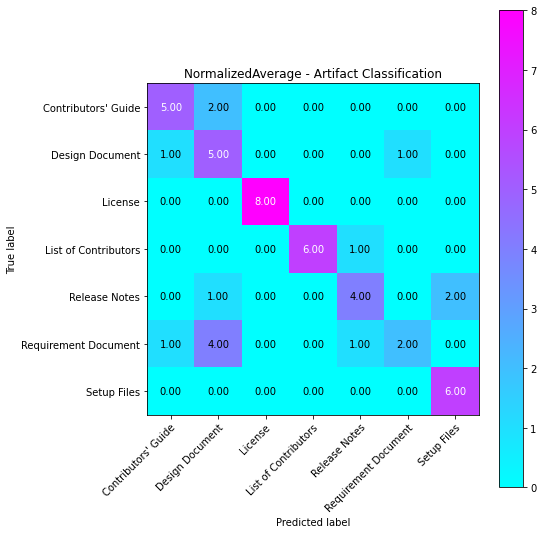

In [117]:
# plot metrics resume
uf.custom_metrics(mean_of_conf_matrix_arrays, np.unique(y_test))

### Voting Classifier

In [101]:
final_mean = []
conf_matrix_list_of_arrays = []
for i in range(10):

    accrs = []
    # conf_matrix_list_of_arrays = []
    k=10
    fold = 0
    sss = StratifiedShuffleSplit(n_splits=k, test_size=0.2, random_state=42)

    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        fold +=1

        X_train = vectorizer.fit_transform(X_train)
        X_train = normalizer(X_train) # Use for mNB
        X_test = vectorizer.transform(X_test)
        X_test = normalizer(X_test) # Use for mNB

        dic_y_mapping = {n:label for n,label in enumerate(np.unique(y_train))}

        model = VotingClassifier(estimators=[
            ('svm', clf1),('rf', clf2), ('mnb', clf3), ('tree', clf4)], voting='hard',weights=[1,1,2,1])
        model = model.fit(X_train, y_train)

        predicted = model.predict(X_test)
        accr = metrics.accuracy_score(y_test, predicted)
        #
        conf_matrix = confusion_matrix(y_test, predicted)
        conf_matrix_list_of_arrays .append(conf_matrix)
        #    
        accrs.append(accr)
    #     print(metrics.classification_report(y_test, predicted))

        print(f'Iteração: {i+1} Fold: {fold} Accuracy: {accr}, Mean Accuracy: {sum(accrs)/fold}')
    final_mean.append(sum(accrs)/k)

# means for Confusion Matrix
mean_of_conf_matrix_arrays = np.mean(conf_matrix_list_of_arrays, axis=0)

Number of samples with no words found: 0 / 224
Number of samples with no words found: 0 / 56
Iteração: 1 Fold: 1 Accuracy: 0.7678571428571429, Mean Accuracy: 0.7678571428571429
Number of samples with no words found: 0 / 224
Number of samples with no words found: 0 / 56
Iteração: 1 Fold: 2 Accuracy: 0.6428571428571429, Mean Accuracy: 0.7053571428571429
Number of samples with no words found: 0 / 224
Number of samples with no words found: 0 / 56
Iteração: 1 Fold: 3 Accuracy: 0.6428571428571429, Mean Accuracy: 0.6845238095238096
Number of samples with no words found: 0 / 224
Number of samples with no words found: 0 / 56
Iteração: 1 Fold: 4 Accuracy: 0.6428571428571429, Mean Accuracy: 0.6741071428571429
Number of samples with no words found: 0 / 224
Number of samples with no words found: 0 / 56
Iteração: 1 Fold: 5 Accuracy: 0.6785714285714286, Mean Accuracy: 0.675
Number of samples with no words found: 0 / 224
Number of samples with no words found: 0 / 56
Iteração: 1 Fold: 6 Accuracy: 0.696

In [103]:
print(f'Iterações: {len(final_mean)} | CV: {fold} | Média Final: {sum(final_mean)/len(final_mean)}')

Iterações: 10 | CV: 10 | Média Final: 0.6839285714285712


### Evaluate

                                          Metrics Resume                                          
Class Name          	 Precision	    Recall	  F1-Score	       MCC	       AUC
Contributors' Guide 	      0.71	      0.71	      0.71	      0.67	      0.83
Design Document     	      0.42	      0.71	      0.53	      0.45	      0.78
License             	       1.0	       1.0	       1.0	       1.0	       1.0
List of Contributors	       1.0	      0.86	      0.92	      0.92	      0.93
Release Notes       	      0.67	      0.57	      0.62	      0.56	      0.76
Requirement Document	      0.67	      0.25	      0.36	      0.35	      0.61
Setup Files         	      0.75	       1.0	      0.86	      0.85	      0.98

Macro Average       	      0.74	      0.73	      0.71	      0.68	      0.84
Micro Average       	      0.72	      0.72	      0.72	      0.85	      0.84


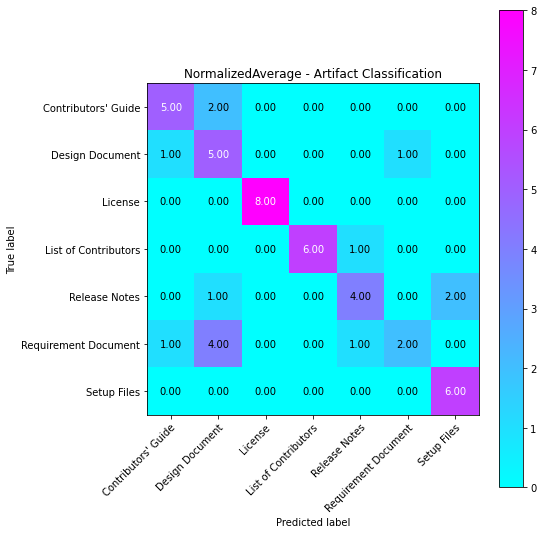

In [119]:
# plot metrics resume
uf.custom_metrics(mean_of_conf_matrix_arrays, np.unique(y_test))